In [5]:
# packages
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from solver_1d import false_transient_one_iteration_python
from supportfunctions import PDESolver_2d, finiteDiff
from numba import njit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg
import SolveLinSys
import time
from derivative import derivatives_2d
from solver_ode import solve_ode, solve_ode_one, derivative_1d, solve_ode_neumann
from solver_jump import approach_one_100, solve_smooth_100, solve_jump_100
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import matplotlib.transforms as transforms
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['figure.facecolor'] = 'w'
mpl.rcParams['figure.edgecolor'] = 'w'

In [6]:
# parameters
δ = 0.01
η = 0.032
μ = 1.86/1000
θ_list = pd.read_csv("../data/model144.csv", header=None)[0].to_numpy()
θ_list = θ_list/1000
σy = 1.2*np.mean(θ_list)
# damage function
# ȳ = 1.9
γ1 = 0.00017675
γ2 = 2*0.0022
# γ3_list = np.linspace(0, 1/3, 40)
# γ3_list = np.array([0, 0.0197*2, 0.3853*2])
y_jump=2
y = 2.5
damage_min =  γ1*(y- y_jump+2) + γ2/2*(y - y_jump+2)**2
damage_max =  γ1*(y- y_jump+2) + γ2/2*(y - y_jump+2)**2 + 1/3/2*(y - y_jump)**2
damages = np.linspace(np.exp(-damage_max), np.exp(-damage_min), 40)
γ3_list = 2*( - np.log(damages) - γ1*(y- y_jump+2) - γ2/2*(y - y_jump+2)**2)/(y - y_jump)**2
γ3_list = np.flip(γ3_list)
γ3_list[0] = 0

dmg_weight = np.ones(len(γ3_list))/len(γ3_list)
# capital parameters
invkap = 0.09
α = 0.115
μk = - 0.043
σk = 0.0085
κ = 6.667
k0 = 80/α

In [7]:
y_step = .04
y_grid = np.arange(0., 4., y_step)

k_step = 0.5
k_grid = np.arange(0., 9, k_step)

(y_mat, k_mat) = np.meshgrid(y_grid, k_grid, indexing = 'ij')
stateSpace = np.hstack([y_mat.reshape(-1,1, order='F'), k_mat.reshape(-1,1,order='F')])
hy = y_grid[1] - y_grid[0]
hk = k_grid[1] - k_grid[0]
n_y = len(y_grid)
n_k = len(k_grid)

In [8]:
def solve_new(y_grid, k_grid, args, ϵ=0.5, max_iter=2000, tol=1e-6):
    δ, η, α, μk, σk, κ, θ, θ_list, σy, γ1, γ2, γ3, y_bar, ξa, ϑ_bar, λ_bar = args
    n_y = len(y_grid)
    n_k = len(k_grid)
    dy = y_grid[1] - y_grid[0]
    dk = k_grid[1] - k_grid[0]
    (y_mat, k_mat) = np.meshgrid(y_grid, k_grid, indexing = 'ij')
    stateSpace = np.hstack([y_mat.reshape(-1,1, order='F'), k_mat.reshape(-1,1,order='F')])
    πa_o = np.ones((len(θ_list), n_y, n_k))/len(θ_list)
    θ_mat = np.zeros((len(θ_list), n_y, n_k))
    for i in range(len(θ_list)):
        θ_mat[i] = θ_list[i]
    πa = πa_o
    
    dΛ = γ1 + γ2*y_mat + γ3*(y_mat - y_bar)*(y_mat >y_bar)
    ddΛ = γ2 + γ3*(y_mat > y_bar)
    v0 =  -  η*y_mat**2 + k_mat**2
    ems_new = η*y_mat**2 + k_mat**2
    ems_old = ems_new
    episode = 0
    lhs_error = 0.5
    vd = - 1/δ
    while lhs_error > tol:
        if episode ==0:
            i = 0
            ems = ems_new
            mc_new = 1/(α - i - np.exp(ϑ_bar)*(1 - np.exp(λ_bar)*(ems/np.exp(k_mat))**θ) )
        else:
            vold = v0.copy()
        v0_dy = derivatives_2d(v0,0,1,dy)
        v0_dyy = derivatives_2d(v0,0,2,dy)
        v0_dk = derivatives_2d(v0,1,1,dk)
#         v0_dy2[v0_dy2 > - 1e-15] =  - 1e-15
        v0_dkk = derivatives_2d(v0,1,2,dk)
        # updating controls
        mc = mc_new
        i_new = 1 - mc/v0_dk
        # update emission
        a = v0_dyy*σy**2 + vd*ddΛ*σy**2 - mc*θ*np.exp(ϑ_bar)*np.exp(2*(λ_bar-k_mat))
        b = mc*θ*np.exp(ϑ_bar + λ_bar - k_mat) + v0_dy*np.sum(θ_mat*πa, axis=0) \
            + vd*dΛ*np.sum(θ_mat*πa, axis=0)
        ems_new = -b/a
        ems_new[ems_new < 1e-15] = 1e-15
        mc_new = 1/(α - i_new - np.exp(ϑ_bar)*(1 - np.exp(λ_bar)*(ems_new/np.exp(k_mat))**θ) )
#         ems_new[ems_new <= 1e-15] = 1e-15
#         ems = ems_new*0.5 + ems_old*0.5

#         weight = np.array([-1/ξa*v0_dy2*λ*ems*θ for θ in θ_list])
#         weight = weight - np.max(weight, axis=0)
#         πa = πa_o*np.exp(weight)
#         πa[πa<1e-15] = 1e-15
#         πa = πa/np.sum(πa, axis=0)
        print(np.min(ems_new))
        # HJB coefficient
        entropy = np.sum(πa*(np.log(πa) - np.log(πa_o)), axis=0)
        A =  -δ*np.ones(y_mat.shape)
        B_y = np.sum(θ_mat*πa, axis=0)*ems
        B_k = μk + i_new - 0.5*κ*i_new**2 - 0.5*σk**2
        C_yy = 0.5*ems**2*σy**2
        C_kk = 0.5*σk**2*np.ones(y_mat.shape)
        D = np.log(mc_new) + k_mat + vd*(dΛ*np.sum(θ_mat*πa, axis=0)*ems_new + 0.5*ddΛ*σy**2*ems_new**2) \
            + ξa*entropy
        # PDE solver
        out = PDESolver_2d(stateSpace, A, B_y, B_k, C_yy, C_kk, D, v0, ϵ, solverType = 'False Transient')
        out_comp = out[2].reshape(v0.shape,order = "F")
        rhs = A*v0 + B_y*v0_dy + B_k*v0_dk + C_yy*v0_dyy + C_kk*v0_dkk  + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((out_comp - v0)/ϵ))
        #     if episode % 1 == 0:
        print("Episode {:d}: PDE Error: {:.12f}; False Transient Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode, rhs_error, lhs_error, out[0], out[1]))
        episode += 1
        v0 = out_comp
        ems_old = ems_new
    result = dict(v0=v0, ems=ems, πa=πa)
    return result

In [70]:
# ϑ_bar = -2.6979578599514364
ϑ_bar = -2.0
# λ_bar = 4.285437365577687
λ_bar = 4.2
np.exp(λ_bar), 1/(0.115 - np.exp(ϑ_bar)*(( 1 - np.exp(λ_bar)*0.3)**2)), np.exp(2.00857),np.exp(k_mat)[0]

(66.68633104092515,
 -0.02050382802086861,
 7.45265243074527,
 array([1.00000000e+00, 1.64872127e+00, 2.71828183e+00, 4.48168907e+00,
        7.38905610e+00, 1.21824940e+01, 2.00855369e+01, 3.31154520e+01,
        5.45981500e+01, 9.00171313e+01, 1.48413159e+02, 2.44691932e+02,
        4.03428793e+02, 6.65141633e+02, 1.09663316e+03, 1.80804241e+03,
        2.98095799e+03, 4.91476884e+03]))

In [71]:
θ = 2
y_bar = 2
ξa = 100_000
# ϑ_bar = -2.6979578599514364
ϑ_bar = -2.0
# λ_bar = 4.285437365577687
λ_bar = 4.2
γ3 = γ3_list[0]

α=0.115

ϵ=0.5
max_iter=2000
tol=1e-6

n_y = len(y_grid)
n_k = len(k_grid)
dy = y_grid[1] - y_grid[0]
dk = k_grid[1] - k_grid[0]

(y_mat, k_mat) = np.meshgrid(y_grid, k_grid, indexing = 'ij')
stateSpace = np.hstack([y_mat.reshape(-1,1, order='F'), k_mat.reshape(-1,1,order='F')])
πa_o = np.ones((len(θ_list), n_y, n_k))/len(θ_list)
θ_mat = np.zeros((len(θ_list), n_y, n_k))
for i in range(len(θ_list)):
    θ_mat[i] = θ_list[i]
πa = πa_o

dΛ = γ1 + γ2*y_mat + γ3*(y_mat - y_bar)*(y_mat >y_bar)
ddΛ = γ2 + γ3*(y_mat > y_bar)
v0 =  -  η/δ*y_mat**2 + 1.4*k_mat
ems_new = 0*np.ones(y_mat.shape)
ems = 0*np.ones(y_mat.shape)
i = 0
mc = 1/(α - i - np.exp(ϑ_bar)*(1 - np.exp(λ_bar)*(ems_new/np.exp(k_mat)))**θ )
mc[mc < 1e-15] = 1e-15

episode = 0
lhs_error = 0.5
vd = - 1/δ

while lhs_error > tol and episode <= 100:
    vold = v0.copy()
    v0_dy = derivatives_2d(v0,0,1,dy)
    v0_dyy = derivatives_2d(v0,0,2,dy)
    v0_dk = derivatives_2d(v0,1,1,dk)
    v0_dk[v0_dk < 1e-15] =  1e-15
    v0_dkk = derivatives_2d(v0,1,2,dk)
    # updating controls
    
    i_new = 1 - 1/κ*mc/v0_dk
#     i_new = i_new*0.5 + i*0.5
#     update emission
    a = v0_dyy*σy**2 + vd*ddΛ*σy**2 - mc*θ*np.exp(ϑ_bar)*np.exp(2*(λ_bar-k_mat))
    b = mc*θ*np.exp(ϑ_bar + λ_bar - k_mat) + v0_dy*np.sum(θ_mat*πa, axis=0) \
        + vd*dΛ*np.sum(θ_mat*πa, axis=0)
    ems_new = - b/a
#     ems_new[ems_new < 1e-15] = 1e-15
    ratio = (1 - np.exp(λ_bar)*(ems_new/np.exp(k_mat)))*( (1 - np.exp(λ_bar)*(ems_new/np.exp(k_mat))) > 0)
    mc_new = 1/(α - i_new - np.exp(ϑ_bar)*ratio**θ)
    ems_new[ems_new <= 1e-15] = 1e-15
    ems = ems_new*0.5 + ems*0.5
    mc_new[mc_new <= 1e-15] = 1e-15
#     mc_new = mc_new*0.1 + mc*0.9
#         weight = np.array([-1/ξa*v0_dy2*λ*ems*θ for θ in θ_list])
#         weight = weight - np.max(weight, axis=0)
#         πa = πa_o*np.exp(weight)
#         πa[πa<1e-15] = 1e-15
#         πa = πa/np.sum(πa, axis=0)
    print(np.min(ems_new))
    print(np.min(mc_new))
    # HJB coefficient
    entropy = np.sum(πa*(np.log(πa) - np.log(πa_o)), axis=0)
    A =  -δ*np.ones(y_mat.shape)
    B_y = np.sum(θ_mat*πa, axis=0)*ems_new
    B_k = μk + i_new - 0.5*κ*i_new**2 - 0.5*σk**2
    C_yy = 0.5*ems_new**2*σy**2
    C_kk = 0.5*σk**2*np.ones(y_mat.shape)
    D = - np.log(mc_new) + k_mat + vd*(dΛ*np.sum(θ_mat*πa, axis=0)*ems_new + 0.5*ddΛ*σy**2*ems_new**2) \
        + ξa*entropy
    # PDE solver
    out = PDESolver_2d(stateSpace, A, B_y, B_k, C_yy, C_kk, D, v0, ϵ, solverType = 'False Transient')
    out_comp = out[2].reshape(v0.shape,order = "F")
    rhs = A*v0 + B_y*v0_dy + B_k*v0_dk + C_yy*v0_dyy + C_kk*v0_dkk  + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((out_comp - v0)/ϵ))
    #     if episode % 1 == 0:
    print("Episode {:d}: PDE Error: {:.12f}; False Transient Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode, rhs_error, lhs_error, out[0], out[1]))
    episode += 1
    v0 = out_comp
    ems = ems_new
#     mc = mc_new

1e-15
1e-15
Episode 0: PDE Error: 40.094437019911; False Transient Error: 38.734958932091; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1: PDE Error: 38.734958932091; False Transient Error: 37.388015577429; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 2: PDE Error: 37.388015577429; False Transient Error: 36.053515881825; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 3: PDE Error: 36.053515881825; False Transient Error: 34.731369367134; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 4: PDE Error: 34.731369367134; False Transient Error: 33.421486147486; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 5: PDE Error: 33.421486147486; False Transient Error: 32.123776925633; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 6: PDE Error: 32.123776925633; False Transient Error: 30.838152989319; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 7: PDE Error: 30.838152989319; False Transient Error: 29

1e-15
1e-15
Episode 65: PDE Error: 32.225942593308; False Transient Error: 32.904427615866; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 66: PDE Error: 32.904427615867; False Transient Error: 33.575363891570; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 67: PDE Error: 33.575363891569; False Transient Error: 34.238809738559; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 68: PDE Error: 34.238809738559; False Transient Error: 34.894823081543; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 69: PDE Error: 34.894823081544; False Transient Error: 35.543461454263; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 70: PDE Error: 35.543461454265; False Transient Error: 36.184782001958; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 71: PDE Error: 36.184782001958; False Transient Error: 36.818841483795; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 72: PDE Error: 36.818841483795; False Transient E

In [114]:
θ = 2
y_bar = 2
ξa = 100_000
ϑ_bar = -2.6979578599514364
# ϑ_bar = -3.0
# λ_bar = 4.285437365577687
λ_bar = 4.2
γ3 = γ3_list[0]

α=0.115

ϵ=0.5
max_iter=2000
tol=1e-6

n_y = len(y_grid)
n_k = len(k_grid)
dy = y_grid[1] - y_grid[0]
dk = k_grid[1] - k_grid[0]

(y_mat, k_mat) = np.meshgrid(y_grid, k_grid, indexing = 'ij')
stateSpace = np.hstack([y_mat.reshape(-1,1, order='F'), k_mat.reshape(-1,1,order='F')])
πa_o = np.ones((len(θ_list), n_y, n_k))/len(θ_list)
θ_mat = np.zeros((len(θ_list), n_y, n_k))
for i in range(len(θ_list)):
    θ_mat[i] = θ_list[i]
πa = πa_o

dΛ = γ1 + γ2*y_mat + γ3*(y_mat - y_bar)*(y_mat >y_bar)
ddΛ = γ2 + γ3*(y_mat > y_bar)
# v0 =  -  η/δ*y_mat**2 + 1.4*k_mat
v0 =  -  η/δ*y_mat**2 + (1/δ)*k_mat
ems_new = 0*np.ones(y_mat.shape)
ems = 0*np.ones(y_mat.shape)
# i = 0
a_i = κ*(1/δ)
b_i = -(1+α*κ)*(1/δ)
c_i = α*(1/δ) - 1
i = (-b_i - np.sqrt(b_i**2 - 4*a_i*c_i))/(2*a_i)
# stop
mc = 1/(α - i - np.exp(ϑ_bar)*(1 - np.exp(λ_bar)*(ems_new/np.exp(k_mat)))**θ )
mc[mc < 1e-15] = 1e-15

# stop

episode = 0
lhs_error = 0.5
vd = - 1/δ

# while lhs_error > tol and episode <= 100:
while lhs_error > tol:
    vold = v0.copy()
    v0_dy = derivatives_2d(v0,0,1,dy)
    v0_dyy = derivatives_2d(v0,0,2,dy)
    v0_dk = derivatives_2d(v0,1,1,dk)
    v0_dk[v0_dk < 1e-15] =  1e-15
    v0_dkk = derivatives_2d(v0,1,2,dk)
    # updating controls
    
    i_new = 1 - 1/κ*mc/v0_dk
#     i_new = 1/κ - mc/(v0_dk*κ)
    

    
    i_new = i_new*0.05 + i*0.95
#     stop        
#     update emission
    a = v0_dyy*σy**2 + vd*ddΛ*σy**2 - mc*θ*np.exp(ϑ_bar)*np.exp(2*(λ_bar-k_mat))
    b = mc*θ*np.exp(ϑ_bar + λ_bar - k_mat) + v0_dy*np.sum(θ_mat*πa, axis=0) \
        + vd*dΛ*np.sum(θ_mat*πa, axis=0)
    ems_new = - b/a
#     ems_new[ems_new < 1e-15] = 1e-15
    ratio = (1 - np.exp(λ_bar)*(ems_new/np.exp(k_mat)))*( (1 - np.exp(λ_bar)*(ems_new/np.exp(k_mat))) > 0)
    mc_new = 1/(α - i_new - np.exp(ϑ_bar)*ratio**θ)
    ems_new[ems_new <= 1e-15] = 1e-15
    ems = ems_new*0.05 + ems*0.95
    mc_new[mc_new <= 1e-15] = 1e-15
#     mc_new = mc_new*0.1 + mc*0.9
#         weight = np.array([-1/ξa*v0_dy2*λ*ems*θ for θ in θ_list])
#         weight = weight - np.max(weight, axis=0)
#         πa = πa_o*np.exp(weight)
#         πa[πa<1e-15] = 1e-15
#         πa = πa/np.sum(πa, axis=0)
    print(np.min(ems_new))
    print(np.min(mc_new))
    # HJB coefficient
    entropy = np.sum(πa*(np.log(πa) - np.log(πa_o)), axis=0)
    A =  -δ*np.ones(y_mat.shape)
    B_y = np.sum(θ_mat*πa, axis=0)*ems_new
    B_k = μk + i_new - 0.5*κ*i_new**2 - 0.5*σk**2
    C_yy = 0.5*ems_new**2*σy**2
    C_kk = 0.5*σk**2*np.ones(y_mat.shape)
    D = - np.log(mc_new) + k_mat + vd*(dΛ*np.sum(θ_mat*πa, axis=0)*ems_new + 0.5*ddΛ*σy**2*ems_new**2) \
        + ξa*entropy
    # PDE solver
    out = PDESolver_2d(stateSpace, A, B_y, B_k, C_yy, C_kk, D, v0, ϵ, solverType = 'False Transient')
    out_comp = out[2].reshape(v0.shape,order = "F")
    rhs = A*v0 + B_y*v0_dy + B_k*v0_dk + C_yy*v0_dyy + C_kk*v0_dkk  + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((out_comp - v0)/ϵ))
    #     if episode % 1 == 0:
    print("Episode {:d}: PDE Error: {:.12f}; False Transient Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode, rhs_error, lhs_error, out[0], out[1]))
    episode += 1
    v0 = out_comp
    ems = ems_new
#     mc = mc_new
    i = i_new

1e-15
1e-15
Episode 0: PDE Error: 38.166573607876; False Transient Error: 37.976690179012; Iterations: 6; CG Error: 0.000000000009
1e-15
1e-15
Episode 1: PDE Error: 37.771540274337; False Transient Error: 37.583622176397; Iterations: 6; CG Error: 0.000000000006
1e-15
1e-15
Episode 2: PDE Error: 36.234931344905; False Transient Error: 36.054658079130; Iterations: 5; CG Error: 0.000000000011
1e-15
1e-15
Episode 3: PDE Error: 33.732098694764; False Transient Error: 33.564277399428; Iterations: 4; CG Error: 0.000000000031
1e-15
1e-15
Episode 4: PDE Error: 30.418069888495; False Transient Error: 30.266736265911; Iterations: 6; CG Error: 0.000000000023
1e-15
1e-15
Episode 5: PDE Error: 26.429691289510; False Transient Error: 26.298200433665; Iterations: 7; CG Error: 0.000000000078
1e-15
1e-15
Episode 6: PDE Error: 21.887554185752; False Transient Error: 21.778660874129; Iterations: 9; CG Error: 0.000000000005
1e-15
1e-15
Episode 7: PDE Error: 16.897725331181; False Transient Error: 16.813657

1e-15
1e-15
Episode 79: PDE Error: 155.061827597434; False Transient Error: 154.290375718281; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 80: PDE Error: 154.708881607437; False Transient Error: 153.939185678492; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 81: PDE Error: 154.337114979312; False Transient Error: 153.569268635588; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 82: PDE Error: 153.947616178659; False Transient Error: 153.181707639907; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 83: PDE Error: 153.541421829136; False Transient Error: 152.777534157802; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 84: PDE Error: 153.119518968612; False Transient Error: 152.357730316488; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 85: PDE Error: 152.682847225530; False Transient Error: 151.923231069637; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 86: PDE Error: 152.232300916468; Fa

Episode 145: PDE Error: 117.997233089458; False Transient Error: 117.410182178151; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 146: PDE Error: 117.424595297889; False Transient Error: 116.840393330840; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 147: PDE Error: 116.854086194497; False Transient Error: 116.272722581194; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 148: PDE Error: 116.285731162603; False Transient Error: 115.707195186282; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 149: PDE Error: 115.719553664369; False Transient Error: 115.143834491517; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 150: PDE Error: 115.155575339671; False Transient Error: 114.582662029130; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 151: PDE Error: 114.593816100206; False Transient Error: 114.023697611749; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 152: PDE Error: 114.034294218723; False 

1e-15
1e-15
Episode 207: PDE Error: 86.833308294588; False Transient Error: 86.401301785354; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 208: PDE Error: 86.401901389440; False Transient Error: 85.972041183235; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 209: PDE Error: 85.972610807840; False Transient Error: 85.544886375657; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 210: PDE Error: 85.545427519621; False Transient Error: 85.119828377450; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 211: PDE Error: 85.120342464800; False Transient Error: 84.696858173640; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 212: PDE Error: 84.697346557138; False Transient Error: 84.275966723217; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 213: PDE Error: 84.276430688004; False Transient Error: 83.857144962902; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 214: PDE Error: 83.857585729812; False Tra

1e-15
1e-15
Episode 270: PDE Error: 63.428940404898; False Transient Error: 63.113373537009; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 271: PDE Error: 63.113397221368; False Transient Error: 62.799400220047; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 272: PDE Error: 62.799422720205; False Transient Error: 62.486987781082; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 273: PDE Error: 62.487009156204; False Transient Error: 62.176128513427; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 274: PDE Error: 62.176148819820; False Transient Error: 61.866814745877; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 275: PDE Error: 61.866834036938; False Transient Error: 61.559038842504; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 276: PDE Error: 61.559057169028; False Transient Error: 61.252793202788; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 277: PDE Error: 61.252810613000; False Tra

Episode 339: PDE Error: 44.960657046775; False Transient Error: 44.736972185670; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 340: PDE Error: 44.736972873327; False Transient Error: 44.514400868833; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 341: PDE Error: 44.514401522165; False Transient Error: 44.292936837799; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 342: PDE Error: 44.292937458458; False Transient Error: 44.072574585360; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 343: PDE Error: 44.072575174990; False Transient Error: 43.853308631657; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 344: PDE Error: 43.853309191776; False Transient Error: 43.635133523992; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 345: PDE Error: 43.635134056111; False Transient Error: 43.418043836762; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 346: PDE Error: 43.418044342285; False Transient Error

1e-15
Episode 405: PDE Error: 32.349882968160; False Transient Error: 32.188938276679; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 406: PDE Error: 32.188938299953; False Transient Error: 32.028794328209; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 407: PDE Error: 32.028794350333; False Transient Error: 31.869447114641; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 408: PDE Error: 31.869447135648; False Transient Error: 31.710892672181; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 409: PDE Error: 31.710892692142; False Transient Error: 31.553127056744; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 410: PDE Error: 31.553127075698; False Transient Error: 31.396146343872; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 411: PDE Error: 31.396146361904; False Transient Error: 31.239946628626; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 412: PDE Error: 31.239946645759; False Transient

1e-15
1e-15
Episode 477: PDE Error: 22.590002240007; False Transient Error: 22.477614169031; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 478: PDE Error: 22.477614169603; False Transient Error: 22.365785243288; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 479: PDE Error: 22.365785243867; False Transient Error: 22.254512680367; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 480: PDE Error: 22.254512680919; False Transient Error: 22.143793712239; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 481: PDE Error: 22.143793712736; False Transient Error: 22.033625584714; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 482: PDE Error: 22.033625585216; False Transient Error: 21.924005557295; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 483: PDE Error: 21.924005557807; False Transient Error: 21.814930903172; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 484: PDE Error: 21.814930903598; False Tra

Episode 551: PDE Error: 15.618082195572; False Transient Error: 15.540380294042; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 552: PDE Error: 15.540380294051; False Transient Error: 15.463064969132; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 553: PDE Error: 15.463064969131; False Transient Error: 15.386134297572; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 554: PDE Error: 15.386134297620; False Transient Error: 15.309586365693; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 555: PDE Error: 15.309586365751; False Transient Error: 15.233419269316; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 556: PDE Error: 15.233419269294; False Transient Error: 15.157631113681; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 557: PDE Error: 15.157631113736; False Transient Error: 15.082220013574; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 558: PDE Error: 15.082220013625; False Transient Error

1e-15
1e-15
Episode 621: PDE Error: 11.015478852564; False Transient Error: 10.960675475144; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 622: PDE Error: 10.960675475176; False Transient Error: 10.906144751381; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 623: PDE Error: 10.906144751432; False Transient Error: 10.851885324737; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 624: PDE Error: 10.851885324774; False Transient Error: 10.797895845499; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 625: PDE Error: 10.797895845515; False Transient Error: 10.744174970641; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 626: PDE Error: 10.744174970688; False Transient Error: 10.690721363833; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 627: PDE Error: 10.690721363861; False Transient Error: 10.637533695350; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 628: PDE Error: 10.637533695365; False Tra

1e-15
Episode 684: PDE Error: 8.045286055119; False Transient Error: 8.005259756319; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 685: PDE Error: 8.005259756337; False Transient Error: 7.965432593344; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 686: PDE Error: 7.965432593348; False Transient Error: 7.925803575432; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 687: PDE Error: 7.925803575442; False Transient Error: 7.886371716850; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 688: PDE Error: 7.886371716858; False Transient Error: 7.847136036631; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 689: PDE Error: 7.847136036675; False Transient Error: 7.808095558838; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 690: PDE Error: 7.808095558875; False Transient Error: 7.769249312230; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 691: PDE Error: 7.769249312244; False Transient Error: 7.73059

Episode 752: PDE Error: 5.731249179007; False Transient Error: 5.702735501472; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 753: PDE Error: 5.702735501501; False Transient Error: 5.674363683058; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 754: PDE Error: 5.674363683097; False Transient Error: 5.646133017959; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 755: PDE Error: 5.646133017981; False Transient Error: 5.618042803944; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 756: PDE Error: 5.618042803972; False Transient Error: 5.590092342223; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 757: PDE Error: 5.590092342261; False Transient Error: 5.562280937513; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 758: PDE Error: 5.562280937547; False Transient Error: 5.534607898022; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 759: PDE Error: 5.534607898059; False Transient Error: 5.50707253532

1e-15
1e-15
Episode 828: PDE Error: 3.923092942377; False Transient Error: 3.903575066972; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 829: PDE Error: 3.903575066995; False Transient Error: 3.884154295461; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 830: PDE Error: 3.884154295484; False Transient Error: 3.864830144732; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 831: PDE Error: 3.864830144732; False Transient Error: 3.845602133995; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 832: PDE Error: 3.845602134062; False Transient Error: 3.826469785061; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 833: PDE Error: 3.826469785113; False Transient Error: 3.807432621936; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 834: PDE Error: 3.807432621951; False Transient Error: 3.788490171049; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 835: PDE Error: 3.788490171082; False Transient Error: 3

1e-15
1e-15
Episode 899: PDE Error: 2.753202861819; False Transient Error: 2.739505335070; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 900: PDE Error: 2.739505335092; False Transient Error: 2.725875955271; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 901: PDE Error: 2.725875955284; False Transient Error: 2.712314383316; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 902: PDE Error: 2.712314383333; False Transient Error: 2.698820281883; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 903: PDE Error: 2.698820281872; False Transient Error: 2.685393315252; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 904: PDE Error: 2.685393315295; False Transient Error: 2.672033149531; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 905: PDE Error: 2.672033149537; False Transient Error: 2.658739452272; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 906: PDE Error: 2.658739452276; False Transient Error: 2

Episode 964: PDE Error: 1.990875939617; False Transient Error: 1.980971084151; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 965: PDE Error: 1.980971084196; False Transient Error: 1.971115506625; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 966: PDE Error: 1.971115506644; False Transient Error: 1.961308961800; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 967: PDE Error: 1.961308961820; False Transient Error: 1.951551205777; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 968: PDE Error: 1.951551205828; False Transient Error: 1.941841995787; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 969: PDE Error: 1.941841995814; False Transient Error: 1.932181090328; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 970: PDE Error: 1.932181090380; False Transient Error: 1.922568249072; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 971: PDE Error: 1.922568249098; False Transient Error: 1.91300323291

Episode 1025: PDE Error: 1.468636883051; False Transient Error: 1.461330231847; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1026: PDE Error: 1.461330231909; False Transient Error: 1.454059932163; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1027: PDE Error: 1.454059932201; False Transient Error: 1.446825803141; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1028: PDE Error: 1.446825803169; False Transient Error: 1.439627664789; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1029: PDE Error: 1.439627664828; False Transient Error: 1.432465338126; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1030: PDE Error: 1.432465338156; False Transient Error: 1.425338644884; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1031: PDE Error: 1.425338644904; False Transient Error: 1.418247407848; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1032: PDE Error: 1.418247407868; False Transient Error: 1.411

1e-15
1e-15
Episode 1102: PDE Error: 1.000294026818; False Transient Error: 0.995317439621; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1103: PDE Error: 0.995317439667; False Transient Error: 0.990365611564; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1104: PDE Error: 0.990365611608; False Transient Error: 0.985438419470; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1105: PDE Error: 0.985438419499; False Transient Error: 0.980535740746; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1106: PDE Error: 0.980535740796; False Transient Error: 0.975657453491; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1107: PDE Error: 0.975657453511; False Transient Error: 0.970803436277; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1108: PDE Error: 0.970803436298; False Transient Error: 0.965973568455; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1109: PDE Error: 0.965973568472; False Transient 

1e-15
1e-15
Episode 1178: PDE Error: 0.684710490900; False Transient Error: 0.681303971025; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1179: PDE Error: 0.681303971058; False Transient Error: 0.677914399028; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1180: PDE Error: 0.677914399048; False Transient Error: 0.674541690561; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1181: PDE Error: 0.674541690596; False Transient Error: 0.671185761741; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1182: PDE Error: 0.671185761789; False Transient Error: 0.667846529090; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1183: PDE Error: 0.667846529140; False Transient Error: 0.664523909531; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1184: PDE Error: 0.664523909569; False Transient Error: 0.661217820496; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1185: PDE Error: 0.661217820535; False Transient 

1e-15
1e-15
Episode 1252: PDE Error: 0.473389272987; False Transient Error: 0.471034102404; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1253: PDE Error: 0.471034102423; False Transient Error: 0.468690649119; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1254: PDE Error: 0.468690649160; False Transient Error: 0.466358854836; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1255: PDE Error: 0.466358854886; False Transient Error: 0.464038661543; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1256: PDE Error: 0.464038661542; False Transient Error: 0.461730011448; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1257: PDE Error: 0.461730011464; False Transient Error: 0.459432847194; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1258: PDE Error: 0.459432847199; False Transient Error: 0.457147111621; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1259: PDE Error: 0.457147111623; False Transient 

Episode 1327: PDE Error: 0.325659521416; False Transient Error: 0.324039324762; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1328: PDE Error: 0.324039324775; False Transient Error: 0.322427188781; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1329: PDE Error: 0.322427188811; False Transient Error: 0.320823073387; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1330: PDE Error: 0.320823073430; False Transient Error: 0.319226938707; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1331: PDE Error: 0.319226938681; False Transient Error: 0.317638744906; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1332: PDE Error: 0.317638744939; False Transient Error: 0.316058452627; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1333: PDE Error: 0.316058452659; False Transient Error: 0.314486022522; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1334: PDE Error: 0.314486022530; False Transient Error: 0.312

Episode 1396: PDE Error: 0.230837051471; False Transient Error: 0.229688608379; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1397: PDE Error: 0.229688608378; False Transient Error: 0.228545878985; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1398: PDE Error: 0.228545879000; False Transient Error: 0.227408834784; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1399: PDE Error: 0.227408834808; False Transient Error: 0.226277447538; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1400: PDE Error: 0.226277447553; False Transient Error: 0.225151689097; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1401: PDE Error: 0.225151689126; False Transient Error: 0.224031531427; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1402: PDE Error: 0.224031531418; False Transient Error: 0.222916946652; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1403: PDE Error: 0.222916946717; False Transient Error: 0.221

1e-15
1e-15
Episode 1465: PDE Error: 0.163624094419; False Transient Error: 0.162810044181; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1466: PDE Error: 0.162810044213; False Transient Error: 0.162000043922; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1467: PDE Error: 0.162000043922; False Transient Error: 0.161194073560; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1468: PDE Error: 0.161194073609; False Transient Error: 0.160392112979; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1469: PDE Error: 0.160392113004; False Transient Error: 0.159594142271; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1470: PDE Error: 0.159594142301; False Transient Error: 0.158800141580; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1471: PDE Error: 0.158800141593; False Transient Error: 0.158010091203; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1472: PDE Error: 0.158010091223; False Transient 

1e-15
1e-15
Episode 1534: PDE Error: 0.115981573199; False Transient Error: 0.115404550430; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1535: PDE Error: 0.115404550444; False Transient Error: 0.114830398416; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1536: PDE Error: 0.114830398432; False Transient Error: 0.114259102884; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1537: PDE Error: 0.114259102933; False Transient Error: 0.113690649639; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1538: PDE Error: 0.113690649653; False Transient Error: 0.113125024502; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1539: PDE Error: 0.113125024532; False Transient Error: 0.112562213391; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1540: PDE Error: 0.112562213429; False Transient Error: 0.112002202404; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1541: PDE Error: 0.112002202449; False Transient 

1e-15
1e-15
Episode 1601: PDE Error: 0.083035318869; False Transient Error: 0.082622207781; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1602: PDE Error: 0.082622207813; False Transient Error: 0.082211152010; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1603: PDE Error: 0.082211152051; False Transient Error: 0.081802141292; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1604: PDE Error: 0.081802141311; False Transient Error: 0.081395165456; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1605: PDE Error: 0.081395165450; False Transient Error: 0.080990214359; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1606: PDE Error: 0.080990214383; False Transient Error: 0.080587277953; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1607: PDE Error: 0.080587277985; False Transient Error: 0.080186346211; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1608: PDE Error: 0.080186346291; False Transient 

1e-15
1e-15
Episode 1665: PDE Error: 0.060344112490; False Transient Error: 0.060043892991; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1666: PDE Error: 0.060043893024; False Transient Error: 0.059745167135; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1667: PDE Error: 0.059745167187; False Transient Error: 0.059447927495; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1668: PDE Error: 0.059447927513; False Transient Error: 0.059152166657; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1669: PDE Error: 0.059152166705; False Transient Error: 0.058857877302; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1670: PDE Error: 0.058857877264; False Transient Error: 0.058565052008; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1671: PDE Error: 0.058565052018; False Transient Error: 0.058273683622; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1672: PDE Error: 0.058273683684; False Transient 

1e-15
1e-15
Episode 1742: PDE Error: 0.041100598902; False Transient Error: 0.040896118233; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1743: PDE Error: 0.040896118272; False Transient Error: 0.040692654999; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1744: PDE Error: 0.040692655030; False Transient Error: 0.040490203952; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1745: PDE Error: 0.040490203978; False Transient Error: 0.040288760254; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1746: PDE Error: 0.040288760263; False Transient Error: 0.040088318718; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1747: PDE Error: 0.040088318739; False Transient Error: 0.039888874351; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1748: PDE Error: 0.039888874399; False Transient Error: 0.039690422200; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1749: PDE Error: 0.039690422219; False Transient 

1e-15
1e-15
Episode 1814: PDE Error: 0.028700648407; False Transient Error: 0.028557859107; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1815: PDE Error: 0.028557859130; False Transient Error: 0.028415780202; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1816: PDE Error: 0.028415780245; False Transient Error: 0.028274408156; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1817: PDE Error: 0.028274408206; False Transient Error: 0.028133739463; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1818: PDE Error: 0.028133739526; False Transient Error: 0.027993770607; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1819: PDE Error: 0.027993770637; False Transient Error: 0.027854498163; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1820: PDE Error: 0.027854498148; False Transient Error: 0.027715918557; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1821: PDE Error: 0.027715918572; False Transient 

1e-15
1e-15
Episode 1882: PDE Error: 0.020445583327; False Transient Error: 0.020343863973; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1883: PDE Error: 0.020343864017; False Transient Error: 0.020242650709; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1884: PDE Error: 0.020242650746; False Transient Error: 0.020141940986; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1885: PDE Error: 0.020141941011; False Transient Error: 0.020041732336; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1886: PDE Error: 0.020041732332; False Transient Error: 0.019942022205; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1887: PDE Error: 0.019942022235; False Transient Error: 0.019842808164; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1888: PDE Error: 0.019842808159; False Transient Error: 0.019744087687; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1889: PDE Error: 0.019744087738; False Transient 

1e-15
1e-15
Episode 1947: PDE Error: 0.014784461143; False Transient Error: 0.014710906566; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1948: PDE Error: 0.014710906644; False Transient Error: 0.014637717970; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1949: PDE Error: 0.014637718001; False Transient Error: 0.014564893499; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1950: PDE Error: 0.014564893534; False Transient Error: 0.014492431335; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1951: PDE Error: 0.014492431394; False Transient Error: 0.014420329739; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1952: PDE Error: 0.014420329715; False Transient Error: 0.014348586839; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1953: PDE Error: 0.014348586832; False Transient Error: 0.014277200869; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 1954: PDE Error: 0.014277200897; False Transient 

Episode 2014: PDE Error: 0.010584720193; False Transient Error: 0.010532059852; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 2015: PDE Error: 0.010532059876; False Transient Error: 0.010479661563; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 2016: PDE Error: 0.010479661603; False Transient Error: 0.010427523950; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 2017: PDE Error: 0.010427523972; False Transient Error: 0.010375645732; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 2018: PDE Error: 0.010375645756; False Transient Error: 0.010324025629; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 2019: PDE Error: 0.010324025652; False Transient Error: 0.010272662315; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 2020: PDE Error: 0.010272662324; False Transient Error: 0.010221554519; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 2021: PDE Error: 0.010221554534; False Transient Error: 0.010

1e-15
1e-15
Episode 2086: PDE Error: 0.007391335583; False Transient Error: 0.007354562746; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 2087: PDE Error: 0.007354562786; False Transient Error: 0.007317972901; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 2088: PDE Error: 0.007317972918; False Transient Error: 0.007281565093; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 2089: PDE Error: 0.007281565111; False Transient Error: 0.007245338405; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 2090: PDE Error: 0.007245338419; False Transient Error: 0.007209291914; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 2091: PDE Error: 0.007209291961; False Transient Error: 0.007173424790; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 2092: PDE Error: 0.007173424803; False Transient Error: 0.007137736102; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 2093: PDE Error: 0.007137736142; False Transient 

Episode 2151: PDE Error: 0.005344768675; False Transient Error: 0.005318177791; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 2152: PDE Error: 0.005318177836; False Transient Error: 0.005291719266; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 2153: PDE Error: 0.005291719241; False Transient Error: 0.005265392261; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 2154: PDE Error: 0.005265392317; False Transient Error: 0.005239196304; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 2155: PDE Error: 0.005239196334; False Transient Error: 0.005213130637; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 2156: PDE Error: 0.005213130699; False Transient Error: 0.005187194663; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 2157: PDE Error: 0.005187194690; False Transient Error: 0.005161387722; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 2158: PDE Error: 0.005161387740; False Transient Error: 0.005

Episode 2218: PDE Error: 0.003826508774; False Transient Error: 0.003807471359; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 2219: PDE Error: 0.003807471417; False Transient Error: 0.003788528717; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 2220: PDE Error: 0.003788528756; False Transient Error: 0.003769680312; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 2221: PDE Error: 0.003769680372; False Transient Error: 0.003750925658; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 2222: PDE Error: 0.003750925676; False Transient Error: 0.003732264304; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 2223: PDE Error: 0.003732264338; False Transient Error: 0.003713695820; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 2224: PDE Error: 0.003713695882; False Transient Error: 0.003695219770; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 2225: PDE Error: 0.003695219783; False Transient Error: 0.003

1e-15
1e-15
Episode 2289: PDE Error: 0.002685420568; False Transient Error: 0.002672060218; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 2290: PDE Error: 0.002672060250; False Transient Error: 0.002658766382; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 2291: PDE Error: 0.002658766402; False Transient Error: 0.002645538661; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 2292: PDE Error: 0.002645538743; False Transient Error: 0.002632376767; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 2293: PDE Error: 0.002632376789; False Transient Error: 0.002619280363; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 2294: PDE Error: 0.002619280405; False Transient Error: 0.002606249145; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 2295: PDE Error: 0.002606249162; False Transient Error: 0.002593282741; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 2296: PDE Error: 0.002593282751; False Transient 

Episode 2354: PDE Error: 0.001941862233; False Transient Error: 0.001932201201; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 2355: PDE Error: 0.001932201261; False Transient Error: 0.001922588257; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 2356: PDE Error: 0.001922588286; False Transient Error: 0.001913023123; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 2357: PDE Error: 0.001913023170; False Transient Error: 0.001903505574; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 2358: PDE Error: 0.001903505625; False Transient Error: 0.001894035406; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 2359: PDE Error: 0.001894035413; False Transient Error: 0.001884612313; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 2360: PDE Error: 0.001884612332; False Transient Error: 0.001875236143; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 2361: PDE Error: 0.001875236152; False Transient Error: 0.001

Episode 2420: PDE Error: 0.001397199342; False Transient Error: 0.001390248064; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 2421: PDE Error: 0.001390248136; False Transient Error: 0.001383331408; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 2422: PDE Error: 0.001383331445; False Transient Error: 0.001376449123; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 2423: PDE Error: 0.001376449165; False Transient Error: 0.001369601108; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 2424: PDE Error: 0.001369601142; False Transient Error: 0.001362787174; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 2425: PDE Error: 0.001362787223; False Transient Error: 0.001356007160; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 2426: PDE Error: 0.001356007188; False Transient Error: 0.001349260849; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 2427: PDE Error: 0.001349260901; False Transient Error: 0.001

Episode 2492: PDE Error: 0.000975667892; False Transient Error: 0.000970813788; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 2493: PDE Error: 0.000970813827; False Transient Error: 0.000965983869; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 2494: PDE Error: 0.000965983890; False Transient Error: 0.000961177961; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 2495: PDE Error: 0.000961178031; False Transient Error: 0.000956395997; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 2496: PDE Error: 0.000956396018; False Transient Error: 0.000951637812; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 2497: PDE Error: 0.000951637829; False Transient Error: 0.000946903267; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 2498: PDE Error: 0.000946903299; False Transient Error: 0.000942192317; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 2499: PDE Error: 0.000942192338; False Transient Error: 0.000

Episode 2563: PDE Error: 0.000674290403; False Transient Error: 0.000670387766; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 2564: PDE Error: 0.000670387762; False Transient Error: 0.000666368069; Iterations: 17; CG Error: 0.000000000098
1e-15
1e-15
Episode 2565: PDE Error: 0.000668756801; False Transient Error: 0.000663828716; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 2566: PDE Error: 0.000663828767; False Transient Error: 0.000659717560; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 2567: PDE Error: 0.000659717566; False Transient Error: 0.000655749805; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 2568: PDE Error: 0.000655749781; False Transient Error: 0.000651839975; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 2569: PDE Error: 0.000651839969; False Transient Error: 0.000647983667; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 2570: PDE Error: 0.000647983624; False Transient Error: 0.000

1e-15
1e-15
Episode 2641: PDE Error: 0.000420283031; False Transient Error: 0.000416343260; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 2642: PDE Error: 0.000416343204; False Transient Error: 0.000413279922; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 2643: PDE Error: 0.000413279936; False Transient Error: 0.000408823384; Iterations: 17; CG Error: 0.000000000097
1e-15
1e-15
Episode 2644: PDE Error: 0.000412268020; False Transient Error: 0.000408136388; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 2645: PDE Error: 0.000408136389; False Transient Error: 0.000404990467; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 2646: PDE Error: 0.000404990468; False Transient Error: 0.000401841971; Iterations: 18; CG Error: 0.000000000000
1e-15
1e-15
Episode 2647: PDE Error: 0.000401841914; False Transient Error: 0.000397370488; Iterations: 17; CG Error: 0.000000000087
1e-15
1e-15
Episode 2648: PDE Error: 0.000400418653; False Transient 

In [115]:
# ems
# i_new
# np.exp(ϑ_bar)*ratio**θ
# α - i_new - np.exp(ϑ_bar)*ratio**θ
# np.exp(ϑ_bar)*(1 - np.exp(λ_bar)*(ems_new/np.exp(k_mat)))**θ 
# mc
# i
# α - i - np.exp(ϑ_bar)*(1 - np.exp(λ_bar)*(ems_new/np.exp(k_mat)))**θ 
# ϑ_bar

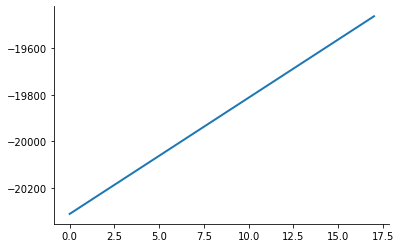

In [116]:
plt.plot(v0[0])

In [117]:
ratio, ems_new

(array([[1.00005864e+03, 6.06959856e+02, 3.68533302e+02, ...,
         1.55256470e+00, 1.33514746e+00, 1.20327723e+00],
        [1.99487615e+03, 1.21034734e+03, 7.34506377e+02, ...,
         2.10278373e+00, 1.66887220e+00, 1.40569154e+00],
        [2.99006211e+03, 1.81395786e+03, 1.10061444e+03, ...,
         2.65320047e+00, 2.00271662e+00, 1.60817829e+00],
        ...,
        [9.74933589e+04, 5.91331274e+04, 3.58664571e+04, ...,
         5.49216701e+01, 3.37051515e+01, 2.08366806e+01],
        [9.85105571e+04, 5.97500600e+04, 3.62406286e+04, ...,
         5.54838854e+01, 3.40461382e+01, 2.10434909e+01],
        [9.95054270e+04, 6.03534792e+04, 3.66066209e+04, ...,
         5.60341326e+01, 3.43798800e+01, 2.12459155e+01]]),
 array([[1.e-15, 1.e-15, 1.e-15, ..., 1.e-15, 1.e-15, 1.e-15],
        [1.e-15, 1.e-15, 1.e-15, ..., 1.e-15, 1.e-15, 1.e-15],
        [1.e-15, 1.e-15, 1.e-15, ..., 1.e-15, 1.e-15, 1.e-15],
        ...,
        [1.e-15, 1.e-15, 1.e-15, ..., 1.e-15, 1.e-15, 1.e-15],


In [118]:
i_new

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [119]:
1/mc[0], 1/mc_new, ems_new, (α - i_new - np.exp(ϑ_bar)*(1 - np.exp(λ_bar)*(ems_new[0,0]/np.exp(k_mat)))**θ)

(array([1.e+15, 1.e+15, 1.e+15, 1.e+15, 1.e+15, 1.e+15, 1.e+15, 1.e+15,
        1.e+15, 1.e+15, 1.e+15, 1.e+15, 1.e+15, 1.e+15, 1.e+15, 1.e+15,
        1.e+15, 1.e+15]),
 array([[1.e+15, 1.e+15, 1.e+15, ..., 1.e+15, 1.e+15, 1.e+15],
        [1.e+15, 1.e+15, 1.e+15, ..., 1.e+15, 1.e+15, 1.e+15],
        [1.e+15, 1.e+15, 1.e+15, ..., 1.e+15, 1.e+15, 1.e+15],
        ...,
        [1.e+15, 1.e+15, 1.e+15, ..., 1.e+15, 1.e+15, 1.e+15],
        [1.e+15, 1.e+15, 1.e+15, ..., 1.e+15, 1.e+15, 1.e+15],
        [1.e+15, 1.e+15, 1.e+15, ..., 1.e+15, 1.e+15, 1.e+15]]),
 array([[1.e-15, 1.e-15, 1.e-15, ..., 1.e-15, 1.e-15, 1.e-15],
        [1.e-15, 1.e-15, 1.e-15, ..., 1.e-15, 1.e-15, 1.e-15],
        [1.e-15, 1.e-15, 1.e-15, ..., 1.e-15, 1.e-15, 1.e-15],
        ...,
        [1.e-15, 1.e-15, 1.e-15, ..., 1.e-15, 1.e-15, 1.e-15],
        [1.e-15, 1.e-15, 1.e-15, ..., 1.e-15, 1.e-15, 1.e-15],
        [1.e-15, 1.e-15, 1.e-15, ..., 1.e-15, 1.e-15, 1.e-15]]),
 array([[-0.9523429, -0.9523429, -0.9523429,

In [120]:
v0_dk

array([[99.99983334, 99.99983334, 99.99983408, ..., 99.99984109,
        99.99983997, 99.99984161],
       [99.99983334, 99.99983334, 99.99983408, ..., 99.99984109,
        99.99983997, 99.99984161],
       [99.99983334, 99.99983334, 99.99983408, ..., 99.99984109,
        99.99983997, 99.99984161],
       ...,
       [99.99983367, 99.99983367, 99.9998344 , ..., 99.99984141,
        99.99984029, 99.99984192],
       [99.99983367, 99.99983367, 99.99983441, ..., 99.99984141,
        99.99984029, 99.99984193],
       [99.99983368, 99.99983368, 99.99983442, ..., 99.99984142,
        99.9998403 , 99.99984193]])

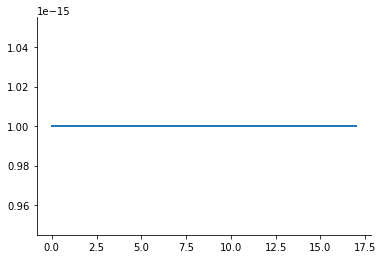

In [121]:
plt.plot(ems[0])

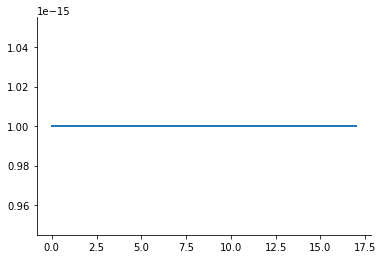

In [110]:
plt.plot(ems[0])

In [111]:
np.exp(ϑ_bar)*(1 - np.exp(λ_bar)*(ems_new/np.exp(k_mat)))

array([[0.04978707, 0.04978707, 0.04978707, ..., 0.04978707, 0.04978707,
        0.04978707],
       [0.04978707, 0.04978707, 0.04978707, ..., 0.04978707, 0.04978707,
        0.04978707],
       [0.04978707, 0.04978707, 0.04978707, ..., 0.04978707, 0.04978707,
        0.04978707],
       ...,
       [0.04978707, 0.04978707, 0.04978707, ..., 0.04978707, 0.04978707,
        0.04978707],
       [0.04978707, 0.04978707, 0.04978707, ..., 0.04978707, 0.04978707,
        0.04978707],
       [0.04978707, 0.04978707, 0.04978707, ..., 0.04978707, 0.04978707,
        0.04978707]])

In [112]:
mc_new, mc 

(array([[1.e-15, 1.e-15, 1.e-15, ..., 1.e-15, 1.e-15, 1.e-15],
        [1.e-15, 1.e-15, 1.e-15, ..., 1.e-15, 1.e-15, 1.e-15],
        [1.e-15, 1.e-15, 1.e-15, ..., 1.e-15, 1.e-15, 1.e-15],
        ...,
        [1.e-15, 1.e-15, 1.e-15, ..., 1.e-15, 1.e-15, 1.e-15],
        [1.e-15, 1.e-15, 1.e-15, ..., 1.e-15, 1.e-15, 1.e-15],
        [1.e-15, 1.e-15, 1.e-15, ..., 1.e-15, 1.e-15, 1.e-15]]),
 array([[1.e-15, 1.e-15, 1.e-15, ..., 1.e-15, 1.e-15, 1.e-15],
        [1.e-15, 1.e-15, 1.e-15, ..., 1.e-15, 1.e-15, 1.e-15],
        [1.e-15, 1.e-15, 1.e-15, ..., 1.e-15, 1.e-15, 1.e-15],
        ...,
        [1.e-15, 1.e-15, 1.e-15, ..., 1.e-15, 1.e-15, 1.e-15],
        [1.e-15, 1.e-15, 1.e-15, ..., 1.e-15, 1.e-15, 1.e-15],
        [1.e-15, 1.e-15, 1.e-15, ..., 1.e-15, 1.e-15, 1.e-15]]))

In [113]:
θ = 2
y_bar = 2
ξa = 100_000
ϑ_bar = 0
λ_bar = 0
γ3 = γ3_list[0]
args = (δ, η, α, μk, σk, κ, θ, θ_list, σy, γ1, γ2, γ3, y_bar, ξa, ϑ_bar, λ_bar)
res = solve_new(y_grid, k_grid, args)

1e-15
Episode 0: PDE Error: nan; False Transient Error: nan; Iterations: 3600; CG Error: nan


<ipython-input-8-9d813179fe27>:61: RuntimeWarning: invalid value encountered in log
  D = np.log(mc_new) + k_mat + vd*(dΛ*np.sum(θ_mat*πa, axis=0)*ems_new + 0.5*ddΛ*σy**2*ems_new**2) \


In [7]:
# simulate
def simulate_logkapital(invkap, αₖ,  σₖ, κ, k0, T=100, dt=1):
    periods = int(T/dt)
    Kt = np.zeros(periods)
    i = invkap
     # log capital
    Kt[0] = np.log(k0)
    k = np.log(k0)
    for t in range(periods-1):
        k +=   (αₖ + i - κ/2*i**2 - .5*σₖ**2)*dt
        Kt[t+1] = k
    return Kt

In [8]:
n_temp = 16
n_carb = 9
n_θ = len(θ_list)
θ_mat = θ_list.reshape(n_temp, n_carb)
θtemp_list = np.average(θ_mat, axis=1)
θcarb_list = np.average(θ_mat, axis=0)

In [17]:
from multiprocessing import Pool

# test for ξ_p = 2
# baseline
ξa = 0.01
ξw = 100_000
# ξp = 5
hy = 0.02
y_bar = 2
y_min = 0
y_max = 4
y_lower = 1.5

jump_interval = np.arange(y_lower,y_bar+hy, hy)
y_grid = np.arange(y_min, y_max+hy, hy)

In [25]:
def ode_y_parallel(args_list):
    with Pool(8) as p:
        res_list = p.starmap(solve_notrun, args_list)
    return res_list        

def ode_y_parallel_def(args_list):
    with Pool(8) as p:
        res_list = p.starmap(solve_smooth_100, args_list)
    return res_list        

In [23]:
def postjump_list(args_list):
    res_list = ode_y_parallel(args_list)
    ϕ_list = np.zeros((len(γ3_list), len(y_grid)))
    ems_list = np.zeros((len(γ3_list), len(y_grid)))
    for j in range(len(γ3_list)):
        ϕ_list[j ] = res_list[ j]['φ']
        ems_list[ j ] = res_list[ j]['ems']
        
    return ϕ_list, ems_list

def postjump_list_def(args_list):
    res_list = ode_y_parallel_def(args_list)
    ϕ_list = np.zeros((len(γ3_list), len(y_grid)))
    ems_list = np.zeros((len(γ3_list), len(y_grid)))
    for j in range(len(γ3_list)):
        ϕ_list[j ] = res_list[ j]['φ']
        ems_list[ j ] = res_list[ j]['ems']
        
    return ϕ_list, ems_list

In [26]:
args_list_1 = []

for γ3_i in γ3_list:
    args_func = (δ, η, θ_list, σy, γ1, γ2, γ3_i, 2, 0.01, 100_000)
    args_iter = (y_grid, args_func, 4000, 1e-7, 2)
    args_list_1.append(args_iter)

args_list_base  = []
for γ3_i in γ3_list:
    args_func = (δ, η, θ_list, σy, γ1, γ2, γ3_i, 2, 100_000, 100_000)
    args_iter = (y_grid, args_func, 4000, 1e-7, 2)
    args_list_base.append(args_iter)

In [28]:
ϕ_list1, ems_list1 = postjump_list(args_list_1)
ϕ_list2, ems_list2 = postjump_list_def(args_list_1)
# ϕ_list_base, ems_list_base = postjump_list(args_list_base)

episode: 613,	 ode error: 0.0001104623867287935,	 ft error: 9.931367550564119e-08
episode: 605,	 ode error: 0.0014831350672399601,	 ft error: 9.922756342983785e-08
episode: 525,	 ode error: 0.0007102770160836436,	 ft error: 9.924464361432683e-08
episode: 1734,	 ode error: 0.003644597052895049,	 ft error: 9.251403021437454e-08
episode: 4000,	 ode error: 8.228173616529045,	 ft error: 0.27920762780017583
episode: 4000,	 ode error: 13.23641016901187,	 ft error: 2.820597848973705e-05
episode: 4000,	 ode error: 1.3905835939894817,	 ft error: 1.3818201956006249e-06
episode: 4000,	 ode error: 0.0067592538422868165,	 ft error: 8.808267060178565e-07
episode: 4000,	 ode error: 11.760872471066216,	 ft error: 0.648726356797475
episode: 784,	 ode error: 1.4764020291921958,	 ft error: 8.296387843387265e-08
episode: 4000,	 ode error: 1.5150922486370788,	 ft error: 1.201317177645933e-05
episode: 4000,	 ode error: 14.314758756475495,	 ft error: 1.9608104278034943e-06
episode: 4000,	 ode error: 0.0486509

In [ ]:
# prep_dict = dict(
#     ϕ_list=ϕ_list, ems_list=ems_list, 
#     ϕ_list_base=ϕ_list_base, ems_list_base=ems_list_base,
#     me_list=me_list, ratio_list=ratio_list
# )

# pickle.dump(prep_dict, open("../data/prep_dict_40.p", "wb"))

In [ ]:
res_dict = pickle.load(open('../data/prep_dict_40.p', 'rb'))

ϕ_list = res_dict['φ_list']
ems_list = res_dict['ems_list']
ϕ_list_base = res_dict['φ_list_base']
ems_list_base = res_dict['ems_list_base']
me_list = res_dict['me_list']
ratio_list = res_dict['ratio_list']

In [ ]:
# construct ϕ_m
pre_jump = np.arange(y_min, 2 + hy, hy)
prepre_jump = np.arange(y_min, y_lower, hy)

In [ ]:
plt.plot(ϕ_list[1])
plt.plot(ϕ_list_base[1])
plt.show()

In [ ]:
def solve_baseline_prep(y_grid, ems_star, args, ϵ=2, tol=1e-8, max_iter=3_000):
    """
    compute jump model with ambiguity over climate models
    """
    δ, η, θ_list, γ1, γ2, γ3, ȳ, dmg_weight, ξp, ξa, ξw, σy = args
#     ems_star = solu['ems']
    # solve for HJB with jump function
#     y_grid_cap = y_grid[:numy_bar+1]
    numy_bar = len(pre_jump)
    dy = y_grid[1] - y_grid[0]
    dΛ = γ1 + γ2*y_grid + γ3*(y_grid - ȳ)*(y_grid>ȳ)
    ddΛ = γ2 + γ3*(y_grid>ȳ)
    πᶜo = np.ones((len(θ_list), len(y_grid)))/len(θ_list)
    θ = θ_list@πᶜo 
    A = -δ*np.ones(y_grid.shape)
    B = θ*ems_star
    C = σy**2*ems_star**2/2
    D = η*np.log(ems_star) + (η-1)/δ*dΛ*ems_star*θ + (η-1)/δ*ddΛ*ems_star**2*σy**2/2
    
    ϕ_bound = np.average(ϕ_list, axis=0, weights=dmg_weight)
    ϕ = ϕ_bound
    episode = 0
    lhs_error = 1
    while lhs_error > tol and episode < max_iter:
        ϕ_old = ϕ.copy()
        dϕdy = derivative_1d(ϕ, 1, dy, (0,0), False, "up")
        dϕdyy = derivative_1d(ϕ, 2, dy, (0,0), False, "up")
        # solver
        ϕ_new = solve_ode(A, B, C, D, y_grid, ϕ, ϵ, (False, ϕ_bound[numy_bar]))
        rhs = -δ*ϕ_new + B*dϕdy + C*dϕdyy + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
        ϕ = ϕ_new
        episode += 1
    print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))

#     dϕdy = derivative_1d(ϕ, 1, dy, "center")
#     dϕdyy = derivative_1d(ϕ, 2, dy, "center")
    
    ME = -(dϕdy+(η-1)/δ*dΛ)*θ - (dϕdyy+(η-1)/δ*ddΛ)*σy**2*ems_star
    ratio = ME/(η/ems_star)

    return ME, ratio

In [ ]:
# me_list = np.zeros((len(γ3_list), len(y_grid)))
# ratio_list = np.zeros((len(γ3_list), len(y_grid)))

# for i in range(len(γ3_list)):
#     args_baseline = (δ, η, θ_list, γ1, γ2, γ3_list[i], 2, dmg_weight, 100_000, 100_000, 100_000, σy )
#     ems_star = ems_list[i]
#     me_baseline = solve_baseline_prep(y_grid, ems_star, args_baseline, ϵ=1)
#     me_list[i] = me_baseline[0]
#     ratio_list[i] = me_baseline[1]

# Step 2: HJB

In [ ]:
ξa = 0.01
ξw = 100_000
σy=1.2*np.mean(θ_list)

loc_21 = np.abs(y_grid - 2.1).argmin()
# num_21 = loc
# numy_bar = len(pre_jump) -1
# y_grid_cap = y_grid[:numy_bar+1]
loc_2 =  np.abs(y_grid - 2).argmin()

ϕ_ref = np.zeros((len(γ3_list), loc_21+1 ))
for i in range(len(γ3_list)):
    ϕ_ref[i] = ϕ_list[i, loc_2]



def solve_interval(y_grid, num_stop, num_bound, ϕ_ref, ϕ_list,
                   args,
                   with_bound=False,
                   ϵ=0.3, tol=1e-8, max_iter=4000): 
    
    ξa, ξw, ξp = args
    r1=1.5
    r2=2.5
    y_grid_cap = y_grid[:num_stop+1]
    y_lower = 1.5
    intensity = r1*(np.exp(r2/2*(y_grid_cap- y_lower)**2)-1) *(y_grid_cap >= y_lower)
    # intensity[96:101] = [1.33, 2.33, 3.33, 4.33, 5.33]
    # ς = 0.25
    # intensity = 1/(np.sqrt(2)*ς)*np.exp(-(y_grid_cap - 2)**2/(2*ς**2))
    # intensity = 0.3/(1.9-1.5)*(y_grid_cap - 1.5)*(y_grid_cap>1.5) + 300*(y_grid_cap - 1.9)**2*(y_grid_cap>1.9)

    
    dΛ = γ1 + γ2*y_grid_cap
    ddΛ = γ2

    ϕ = np.average(ϕ_list, axis=0, weights=dmg_weight)[:num_stop+1]

    
    dy = hy
    ems = η
    ems_old = ems
    episode = 0
    lhs_error = 1
    πᵈo = dmg_weight
    πᶜo = np.ones((len(θ_list), len(y_grid_cap)))/len(θ_list)

    ϕ_average2 = np.average( np.exp(-1/ξp*ϕ_list), weights=dmg_weight, axis=0)
    ϕ_bound = -ξp*np.log(ϕ_average2)


    tol= 1e-8
    ϵ = 0.3
    max_iter = 4000
    while lhs_error > tol and episode < max_iter:
        ϕ_old = ϕ.copy()
        dϕdy = derivative_1d(ϕ, 1, dy, (0,0),  False, "up")
        dϕdyy = derivative_1d(ϕ, 2, dy, (0,0), False, "up")
        # update control
        temp = dϕdy + (η-1)/δ*dΛ 
        weight = np.array([ - 1/ξa*temp*ems*θ for θ in θ_list])
        weight = weight - np.max(weight, axis=0)
        πᶜ = πᶜo*np.exp(weight)
        πᶜ[πᶜ <= 1e-15] = 1e-15
        πᶜ = πᶜ/np.sum(πᶜ, axis=0)
        # update control

        if σy == 0:
            ems_new = - η/(temp*(θ_list@πᶜ))
        else:
            a = (dϕdyy  - 1/ξw*temp**2 + (η-1)/δ*ddΛ)*σy**2
            b = (θ_list@πᶜ)*temp
            c = η
            Δ = b**2 - 4*a*c
            Δ[Δ < 0] = 0
            root1 = (-b - np.sqrt(Δ))/(2*a)
            root2 = (-b + np.sqrt(Δ))/(2*a)
            if root1.all() > 0:
                ems_new = root1
            else:
                ems_new = root2

        ems_new[ems_new < 1e-15] = 1e-15
        ems = ems_new*0.5 + ems_old*0.5



        g_list = np.exp(1/ξp*(ϕ - ϕ_ref))
        # coefficients
        A = -δ*np.ones(y_grid_cap.shape)  - intensity*(dmg_weight@g_list)
        By = (θ_list@πᶜ)*ems
        Cyy = ems**2*σy**2/2
        D = η*np.log(ems) + θ_list@πᶜ*(η-1)/δ*dΛ*ems\
        + ξa*np.sum(πᶜ*(np.log(πᶜ) - np.log(πᶜo)), axis=0) \
        + 1/2*(η-1)/δ*ddΛ*ems**2*σy**2\
        - 1/(2*ξw)*temp**2*ems**2*σy**2\
        + ξp*intensity * (dmg_weight@(1 - g_list + g_list * np.log(g_list)))\
        + intensity*(dmg_weight@(g_list*ϕ_ref))
        # solver

        ϕ_new = solve_ode(A, By, Cyy, D, y_grid_cap, ϕ, ϵ,(with_bound, ϕ_bound[num_bound]))
        rhs = -δ*ϕ_new + By*dϕdy + Cyy*dϕdyy + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((ϕ_new - ϕ_old)/ϵ))
        ϕ = ϕ_new
        episode += 1
        ems_old = ems

    print("episode: {},\t ode error: {},\t ft error: {}".format(episode, rhs_error, lhs_error))
    ent = ξa*np.sum(πᶜ*(np.log(πᶜ) - np.log(πᶜo)), axis=0)

    solution = dict(ϕ=ϕ, ems=ems, g_list=g_list, ϕ_bound=ϕ_bound, dϕ=dϕdy, ddϕ=dϕdyy, πc = πᶜ, en=ent)
    return solution

In [ ]:
ϕ_ref = np.zeros((len(γ3_list), loc_2+1 ))
for i in range(len(γ3_list)):
    ϕ_ref[i] = ϕ_list[i, loc_2]

soluDict = dict()
for ξp in [5,1, 0.3]:
    soluDict[ξp] = solve_interval(
        y_grid, loc_2, loc_2, ϕ_ref, ϕ_list, (0.01, 100_000, ξp), False
    )
    
soluDict[100_000] = solve_interval(
        y_grid, loc_2, loc_2, ϕ_ref, ϕ_list_base, (100_000, 100_000, 100_000), False
    )

In [ ]:
y_grid_cap = y_grid[:loc_2+1]
plt.figure(figsize=(10,5))
plt.plot(y_grid_cap,soluDict[1]['en']/0.01)
plt.ylim(0,0.4)
plt.ylabel('Relative entropy')
plt.xlabel('y')
# plt.savefig('entropy.pdf', bbox_inches='tight')

In [ ]:
plt.figure(figsize=(10,5))
numy_bar = loc_2
plt.plot(y_grid_cap,soluDict[1]['φ'], label="prior to jump")
# plt.plot(y_grid[numy_bar: len(pre_jump)], cert_equiv[numy_bar:])
plt.plot(y_grid[numy_bar:], soluDict[1]['φ_bound'][numy_bar:], label="certainty equivalent", color="black")
plt.plot(y_grid[numy_bar:], np.quantile(ϕ_list[ :, numy_bar:], 0.1, axis=0), label=".10 quantile")
plt.plot(y_grid[numy_bar:], np.quantile(ϕ_list[ :, numy_bar:], 0.33, axis=0), label=".33 quantile")
plt.plot(y_grid[numy_bar:], np.quantile(ϕ_list[ :, numy_bar:], 0.5, axis=0), label=".50 quantile")
plt.plot(y_grid[numy_bar:], np.quantile(ϕ_list[ :, numy_bar:], 0.67, axis=0), label=".67 quantile")
plt.plot(y_grid[numy_bar:], np.quantile(ϕ_list[ :, numy_bar:], 0.9, axis=0), label=".90 quantile")
# plt.plot(y_grid, solution_low["ems"])
# plt.plot(y_grid_cap, ems_ref.T)
# plt.title("Value function", fontsize=12)
plt.xlabel('y')
plt.vlines(2, -8, 4, color="black", linestyle="dashed")
plt.legend()

plt.ylabel('ϕ(y)')
plt.xlim(0,3)
# plt.savefig('value_match.pdf')
plt.show()

In [ ]:
plt.hist(ϕ_list[  :, numy_bar], weights=np.ones_like(ϕ_list[ :, numy_bar])/len(ϕ_list), bins=20, alpha=0.5, ec="gray")
plt.xlabel("$\phi_m(2)$")
# plt.savefig('../figures/histogram_valuefunc.pdf')

In [ ]:
# intensity
r1 = 1.5
r2 = 5
intensity1 = r1*(np.exp(r2/2*(y_grid_cap- y_lower)**2)-1)*(y_grid_cap >= y_lower)
intensity = r1*(np.exp(2.5/2*(y_grid_cap- y_lower)**2)-1)*(y_grid_cap >= y_lower)
# worst_case_intensity = dmg_weight@g_list*intensity1
# plt.plot(y_grid_cap, worst_case_intensity, label="implied worst case intensity")
plt.plot(y_grid_cap, intensity1, label="r2 =5")
plt.plot(y_grid_cap, intensity, label="r2 = 2.5")
plt.xlabel('y')
plt.ylabel('$\mathcal{I}(y)$')
plt.legend()
# plt.savefig('../figures/20_damages_large/intensity_{}.pdf'.format( ξp))

In [ ]:
meDict = {}
ratioDict = {}
for i, ξp in enumerate([100_000, 5, 1, 0.3]):
    args_base = (δ, η, θ_list, γ1, γ2, γ3_list, 2, dmg_weight, ς, 100_000, 100_000, 100_000, σy)
    me, ratio = solve_baseline(y_grid, numy_bar, soluDict[ξp]['ems'], ϕ_list, args_base, ϵ=0.2)
    meDict[ξp] = me
    ratioDict[ξp] = ratio

In [ ]:
for i in [1.6, 1.7, 1.8, 1.9, 2]:
    loc_1 = np.abs(y_grid_cap - i).argmin()
    print(i, intensity1[loc_1])

In [ ]:
dt = 1/4

In [ ]:
for ξp in [100_000, 5, 1, 0.3]:
    plt.plot(y_grid_cap, soluDict[ξp]['ems'], label="{}".format(ξp))
plt.legend()

In [ ]:
def no_jump_simulation(ems, g_list, πc, me, dt, r1, r2):
    y = 1.1
    T = 130
    T = int(T/dt)
    et = np.zeros(T)
    yt = np.zeros(T)
    met = np.zeros(T)
    probt = np.zeros(T)
    gt = np.zeros((T, len(g_list)))
    get_g = interpolate.interp1d(y_grid_cap, g_list)
    πct = np.zeros((T, len(πc)))
    get_π = interpolate.interp1d(y_grid_cap, πc)
    for t in range(T):
#         if y < 1.5:
#             print(t)
        if y <= 2:
            e_i = np.interp(y, y_grid_cap, ems)
            me_i = np.interp(y, y_grid_cap, me)
            intensity = r1*(np.exp(r2/2*(y - y_lower)**2) - 1)*(y > y_lower)
    #             intensity = 0.75*(y - 1.5)*(y>1.5) + 300*(y - 1.9)**2*(y>1.9)
            et[t] = e_i
            met[t] = me_i
    #             met[t] = me_i
            probt[t] = 1-intensity*dt
            yt[t] = y
            g_list = get_g(y)
            gt[t] = g_list
            πc_i  = get_π(y)
            πct[t] = πc_i
            y = y + e_i*np.mean(θ_list)*dt
#         else:
#             break
    yt = yt[np.nonzero(yt)]
    et = et[np.nonzero(et)]
    met = met[np.nonzero(met)]
    probt = probt[np.nonzero(probt)]
    gt = gt[:len(yt)]
    πct = πct[:len(yt)]

    return et, yt, probt, πct, gt, met

In [ ]:
simulDict = dict()
for ξp in [ 100_000, 5, 1, 0.3]:
    solution = soluDict[ξp]
    simulDict[ξp] = no_jump_simulation(ems=solution['ems'],g_list=solution['g_list'],
                                       πc = solution['πc'],
                                   me=meDict[ξp], dt=dt, r1=1.5, r2=2.5)

In [ ]:
# emission
colors = ["tab:red", "darkorange", "darkgreen", "navy"]
names = ['baseline', r"$\xi_p = 5$",r"$ \xi_p = 1$", r"$\xi_p = 0.3$"]
fig, (ax1) = plt.subplots(1, 1, figsize=(8,5))
for i, ξp in enumerate([100_000,  5, 1, 0.3]):
    Yt = simulDict[ξp][1]
    loc = np.abs(Yt - 1.5).argmin()
    ax1.plot(np.arange(0, loc*dt, dt), simulDict[ξp][0][:loc], 
             color=colors[i], linewidth=2.5,
            label=names[i])
    ax1.set_ylabel('Emissions', size=13)
    ax1.set_xlabel('Years', size=13)
    ax1.legend(loc=3)
    ax1.set_ylim(0,6)
#     ax2.plot(np.arange(0, loc*dt, dt), simulDict[ξp][1][:loc])
#     ax2.set_title('Temperature ani')
#     ax2.set_xlabel('Years')

# plt.savefig('../figures/emission_pre_jump.pdf', bbox_inches='tight')

In [ ]:
# log
colors = ["tab:red", "darkorange", "darkgreen", "navy"]
names = ['baseline', r"$\xi_p = 5$",r"$ \xi_p = 1$", r"$\xi_p = 0.3$"]

C0 = (α - invkap)/α*80
fig, ax = plt.subplots(1, 1, figsize=(8,5))
for i, ξp in enumerate([100_000,  5, 1, 0.3]):
    Et = simulDict[ξp][0]
    Yt = simulDict[ξp][1]
    loc = np.abs(Yt - 1.5).argmin()
    logNt = γ1*Yt + γ2/2*Yt**2
    logscc = np.log(1000) + np.log(C0) - logNt - np.log(Et) + np.log(η) - np.log(1-η)
    ax.plot(np.arange(0, loc*dt, dt), logscc[:loc], 
             color=colors[i], linewidth=2.5,
            label=names[i])
    ax.set_ylabel('Emissions', size=13)
    ax.set_xlabel('Years', size=13)
    ax.legend(loc=2)
# plt.savefig('../figures/logscc_pre_jump.pdf', bbox_inches='tight')

In [ ]:
# scc as function of y
colors = [ "navy", "darkorange", "darkgreen", "tab:red",]
names = [ r"$ \xi_p = 0.3$",r"$ \xi_p = 1$", 
         r"$\xi_p = 5$", 'baseline']

C0 = (α - invkap)/α*80

fig, (ax1) = plt.subplots(1, 1, figsize=(8,5))
for i, ξp in enumerate([0.3, 1, 5, 100_000]):
    E = soluDict[ξp]['ems']
#     Et = soluDict[ξp][0]
    SCC = np.log(1000) + np.log(C0)  - (y_grid_cap*γ1 + γ2/2*y_grid_cap**2) \
        -np.log(E) + np.log(η) - np.log(1- η)
#     print(SCCt[0])
#     loc = np.abs(Yt - 1.5).argmin()
    ax1.plot(y_grid_cap[110:151], SCC[110:151], 
             color=colors[i], linewidth=2.5,
            label=names[i])
    ax1.set_ylabel(r'$\log SCC$', size=13)
    ax1.set_xlabel('Temperature anomaly', size=13)
    ax1.legend(loc=2)
    
# fig.savefig('../figures/logscc_pre_jump_y.pdf', bbox_inches="tight")

In [ ]:
colors = ["tab:red", "darkgreen", "navy"]
names = ['baseline', r"$\xi_a = 0.01, \xi_p = 5$", r"$\xi_b = \xi_p = 0.3$"]
fig, (ax1) = plt.subplots(1, 1, figsize=(8,5))
for i, ξp in enumerate([100_000,  5,  0.3]):
    Yt = simulDict[ξp][1]
#     loc = np.abs(Yt - 1.5).argmin()
    ax1.plot(np.arange(0, len(simulDict[ξp][0])*dt, dt), simulDict[ξp][0], 
             color=colors[i], linewidth=2.5,
            label=names[i])
    ax1.set_ylabel('Emissions')
    ax1.set_xlabel('Years')
    ax1.legend(loc=2, fontsize=12)
    ax1.set_ylim(0)
#     ax2.plot(np.arange(0, loc*dt, dt), simulDict[ξp][1][:loc])
#     ax2.set_title('Temperature ani')
#     ax2.set_xlabel('Years')

# fig.savefig('emission_full.png', dpi=500)

In [ ]:
# hist γ3
fig, axes = plt.subplots(1,3, figsize=(19,5))
colors = ["tab:blue", "tab:red", "tab:green"]
names = ['baseline', 
         r"$\xi_a = 0.01, \xi_p = 5$", 
         r"$\xi_a = 0.01, \xi_p = 1$",
         r"$\xi_a =0.01,  \xi_p = 0.3$"]

for i, ξp in enumerate([ 5, 1 ,0.3]):
    axes[i].hist(
        γ3_list, 
        weights=simulDict[100_000][-2][-1]*dmg_weight/np.sum(simulDict[100_000][-2][-1]*dmg_weight), 
        color=colors[1],
        label = names[0],
         bins=20, ec="gray", alpha=0.5)
    axes[i].hist(γ3_list, weights=simulDict[ξp][-2][-1]*dmg_weight/np.sum(simulDict[ξp][-2][-1]*dmg_weight), 
        color=colors[0],
             label = names[i+1],
         bins=20, ec="gray", alpha=0.5)
#     axes[i].legend(loc=2)
    axes[i].set_ylim(0, 0.27)
    
    axes[i].set_xlabel('$γ_3$')
# plt.legend()
# plt.savefig("../figures/damage_hist_distort.pdf", bbox_inches='tight')

In [ ]:
# histograms of the climate models
plt.figure(figsize=(6, 5))
bins = np.linspace(0., 3., 21)
plt.hist(θ_list*1000, weights=np.ones_like(θ_list)/len(θ_list), 
         bins=bins, 
         density = True,
         alpha=0.5, 
         color="tab:red",
         ec = 'gray')
plt.hist(θ_list*1000, weights = simulDict[1][-3][-1], 
         alpha=0.5,
         density=True,
         color="tab:blue", 
         bins=bins,
        ec="gray")

plt.ylim(0,1.5)
plt.xticks(np.arange(0,3+0.5, 0.5))
plt.xlim(.8, 3)
plt.xlabel('Climate sensitivity', size=13)
plt.ylabel('Density', size=13)

# plt.savefig('../figures/climate_worstcase.pdf', bbox_inches='tight')

In [ ]:
T_jump = np.abs(simul_no1[1]-1.5).argmin()
T_stop = (len(simul_no1[0])-1)*dt
T_jump/4, T_stop, simul_no1[1][T_jump]

In [ ]:
# no jump & temperature anomaly
simul_no1 = simulDict[1]
yt = simul_no1[1]
T_jump = (np.abs(simul_no1[1]-1.5).argmin())*dt
T_stop = (len(simul_no1[0])-1)*dt


Years = np.arange(0, T_stop + dt, dt)
prob_no_jump = np.cumprod(simul_no1[2])
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
# fig.suptitle('{} damage specifications'.format(len(dmg_weight)), y=0.99)


ax1.plot(Years, 1 -np.cumprod(simul_no1[-4]))
# ax1.set_title("No jump probability")
ax1.set_xlabel('Years')
ax1.set_ylim(0)
ax1.set_xlim(0,100)
# ax1.hlines(np.min(prob_no_jump), 0, T_stop-1, color="red", linestyle="dashed")
trans = transforms.blended_transform_factory(
    ax1.get_yticklabels()[0].get_transform(), ax1.transData)

# ax1.text(-0.01,np.min(prob_no_jump)+0.05, "{:.05f}".format(np.min(prob_no_jump)), color="red", transform=trans, 
#         ha="right", va="center")

# ax1.text(0.98, -0.061, int(np.ceil(T_stop)), transform=trans, ha="right", va="center")
# ax1.text(1.0, -0.056, int(np.ceil(T_stop)), transform=trans, ha="right", va="center")
ax1.text(1.06, -0.056, 100, transform=trans, ha="right", va="center")
# ax2.text(0.567, 0.9455, int(np.ceil(T_jump)), transform=trans, ha="right", va="center")
ax1.set_xticks(np.arange(0,100, 20))
# ax1.set_xticks([99, 100], minor=True)

ax2.plot(Years, simul_no1[1])
ax2.hlines(1.5, 0, T_jump, color="black", linestyle="dashed")
ax2.vlines(T_jump, 1, 1.5, color="black", linestyle="dashed" )
ax2.hlines(2, 0, T_stop, color="black", linestyle="dashed")
ax2.vlines(T_stop, 1, 2, color="black", linestyle="dashed" )
ax2.set_xlim(0) 
# ax2.set_title('Temperature anomaly')
ax2.set_xlabel('Years')
ax2.set_ylim(1,2.03)
trans = transforms.blended_transform_factory(
    ax2.get_yticklabels()[0].get_transform(), ax2.transData)

ax2.text(0,1.5, 1.5, color="black", transform=trans, ha="right", va="center")

# ax2.text(0.97, 0.948, int(np.ceil(T_stop)), transform=trans, ha="right", va="center")
ax2.text(1.02, 0.948, 100, transform=trans, ha="right", va="center")
# ax2.text(0.567, 0.948, int(np.ceil(T_jump)), transform=trans, ha="right", va="center")
ax2.set_xticks(np.arange(0,100, 20))
ax2.set_xticks([56, 99], minor=True)
fig.tight_layout()

# fig.savefig("../figures/prob_anomaly.pdf")
fig.savefig('prob_anomaly.pdf',dpi=500, bbox_inches='tight')

In [ ]:
T_jump, (len(simul_no1[0])-1)/4

In [ ]:
# scc
logkt = simulate_logkapital(invkap, αₖ,  σₖ, κ, k0, dt=dt, T=120)
MCt = (1 - η)/((α - invkap)*np.exp(logkt))

for i, ξp in enumerate([ 100_000, 5,  1, 0.3]):
    fig = plt.figure(figsize=(8,5))

    et_star = simulDict[ξp][0]
    scc = η/et_star/MCt[:len(et_star)]*1000
    scc0 = simulDict[ξp][-1]/MCt[:len(et_star)]*1000 
    plt.plot(np.arange(0, len(et_star)*dt, dt), scc, color="rebeccapurple", label="Total")

    plt.plot(np.arange(0, len(et_star)*dt, dt), scc -scc0, color="rebeccapurple", 
             linestyle="dashed", label="Uncertainty")
    plt.fill_between(np.arange(0, len(et_star)*dt, dt), np.zeros_like(scc), 
                     scc-scc0, color='rebeccapurple', alpha=.4)
    
    T_jump = (np.abs(simulDict[ξp][1]-1.5).argmin())*dt
#     T_jump = len(et_star)*dt
    
    uncertainty = (scc - scc0)/scc
    for y in [10*4, 30*4, 50*4]:
        print(ξp, y/4, uncertainty[y])
    
    plt.xlim(0, T_jump)
    plt.ylim(0,850)
    plt.xlabel("Years")
    plt.ylabel("SCC ($/tC)")
    plt.legend(loc=2)
    plt.title(r'SCC, pre jump, $\xi_p$ = {}'.format( ξp ))
    print(((scc -scc0)/scc)[int(T_jump/dt)], simulDict[ξp][1][int(T_jump/dt)])
    
#     plt.savefig("../figures/20_damages_large/scc_{}.png".format(ξp), dpi=500)

In [ ]:
###### scc
logkt = simulate_logkapital(invkap, αₖ,  σₖ, κ, k0, dt=dt, T=120)
MCt = (1 - η)/((α - invkap)*np.exp(logkt))

for i, ξp in enumerate([ 100_000, 5,  1, 0.3]):

    et_star = soluDict[ξp]['ems']
    ratio = ratioDict[ξp]
    for y_star in np.arange(1.1, 1.6, 0.1):
        loc = np.abs(y_grid_cap - y_star).argmin()
        print(ξp, y_star, "{:.4f}".format(1-ratio[loc]))
    
#     plt.savefig("../figures/20_damages_large/scc_{}.png".format(ξp), dpi=500)

In [ ]:
def jump_simulation(ems, ems_list, me, ratio, dt, r1, r2):
    θ_mean = np.mean(θ_list)
#     ems = solution['ems']
#     ϕ=solution["φ"]
#     ems_list = res_dict['ems_list']
    y0 = 1.1
    y_lower = 1.5
    T_year = 120
    T = int(T_year/dt)
    et = np.zeros(T+1)
    yt = np.zeros(T+1)
    probt = np.zeros(T+1)
    prob_no = np.ones(T+1)
    
    y = y0
    for t in range(T):
        if y < y_lower:
            e_i = np.interp(y, y_grid_cap, ems)
            intensity = r1*(np.exp(r2/2*(y - y_lower)**2) - 1)*(y > y_lower)
#             intensity = 0.75*(y - 1.5)*(y>1.5) + 300*(y - 1.9)**2*(y>1.9)
            et[t] = e_i
            probt[t] = 1 - intensity*dt
            prob_no[t] = np.cumprod(probt[:t+1])[-1]
            yt[t] = y
            y = y + et[t]*θ_mean*dt
        else:
            T_jump = t
            print(T_jump)
            break
    
    # get time span before 
    et = np.zeros(T+1)
    yt = np.zeros(T+1)
    probt = np.zeros(T+1)
    prob_no = np.ones(T+1)
    y = y0
    for t in range(T):
        print(t)
        if y <= y_bar:
            e_i = np.interp(y, y_grid_cap, ems)
            intensity = r1*(np.exp(r2/2*(y - y_lower)**2) - 1)*(y > y_lower)
#             intensity = 0.75*(y - 1.5)*(y>1.5) + 300*(y - 1.9)**2*(y>1.9)
            et[t] = e_i
            probt[t] = 1- intensity*dt
            prob_no[t] = np.cumprod(probt[:t+1])[-1]
            yt[t] = y
            y = y + et[t]*θ_mean*dt
    
    yt_nojump = yt[np.nonzero(yt)]
    et_nojump = et[np.nonzero(et)]
    
    T_final = len(yt_nojump)
    print(T_final)
    T_extra = T - T_final
    
    PROB = np.zeros((len(dmg_weight)*(T_final-T_jump)+1, T+1))
    EMS = np.zeros((len(dmg_weight)*(T_final - T_jump)+1, T+1))
    Temp_anol = np.zeros((len(dmg_weight)*(T_final - T_jump)+1, T+1))
    YS = np.zeros((len(dmg_weight)*(T_final - T_jump)+1, T+1))
    GS = np.zeros((len(dmg_weight)*(T_final - T_jump)+1, T+1))
    ME = np.zeros((len(dmg_weight)*(T_final - T_jump)+1, T+1))
    RATIO = np.zeros((len(dmg_weight)*(T_final - T_jump)+1, T+1))
    et = np.zeros(T+1)
    yt = np.zeros(T+1)
    probt = np.zeros(T+1)
    prob_no = np.ones(T+1)
    y = y0        
    for t in range(T_jump):
        print(t)
        e_i = np.interp(y, y_grid_cap, ems)
        me_i = np.interp(y, y_grid_cap, me)
        ratio_i = np.interp(y, y_grid_cap, ratio)
        intensity = r1*(np.exp(r2/2*(y - y_lower)**2) - 1)*(y > y_lower)
#         intensity = 0.75*(y - 1.5)*(y>1.5) + 300*(y - 1.9)**2*(y>1.9)
        et[t] = e_i
        probt[t] = 1 - intensity*dt
        prob_no[t] = np.cumprod(probt[:t+1])[-1]
        yt[t] = y
        YS[:,t] = y
        Temp_anol[:, t] = y
        PROB[0, t] = prob_no[t]
        EMS[:, t] = et[t]
        ME[:, t] = me_i
        RATIO[:, t] = ratio_i
        y = y + et[t]*θ_mean*dt
    
    
    
    
    for t in range(T_jump, T_final):
        print(t)
        if t == T_jump:
            intensity = r1*(np.exp(r2/2*(y-y_lower)**2) - 1)*(y > y_lower)
#             intensity = 0.75*(y - 1.5)*(y>1.5) + 300*(y - 1.9)**2*(y>1.9)
            e_stay = np.interp(y, y_grid_cap, ems)
            me_i = np.interp(y, y_grid_cap, me)
            ratio_i = np.interp(y, y_grid_cap, ratio)
            EMS[0, t] = e_stay
            probt[t] = 1-intensity*dt
            prob_no[t] = np.cumprod(probt[:t+1])[-1]
            PROB[0, t] = prob_no[t]
            YS[0, t] = y
            Temp_anol[0, t] = y
            ME[0, t] = me_i
            RATIO[0, t] = ratio_i
            et[t] = e_stay
            yt[t] = y
            y = y + et[t]*θ_mean*dt

            for dmg in range(len(dmg_weight)):
#                 loc = np.abs(yt[t]-y_grid).argmin()
                PROB[dmg+1, t] = intensity*dt*dmg_weight[dmg]
                YS[dmg+1, t] =  2
                EMS[dmg+1, t] = np.interp(2, y_grid, ems_list[dmg])
                ME[dmg+1, t] = np.interp(2, y_grid, me_list[dmg])
                RATIO[dmg+1, t] = np.interp(2, y_grid, ratio_list[dmg])
                Temp_anol[dmg + 1, t] = yt[t]
            
            for t_future in range(1, T_final-T_jump):
                for dmg in range(len(dmg_weight)):
                    id_dmg = dmg + t_future*len(dmg_weight) +1
#                     PROB[id_dmg, t] = PROB[0, t]
                    EMS[id_dmg, t] = e_stay
                    YS[id_dmg, t] = yt[t]
                    ME[id_dmg, t] = me_i
                    RATIO[id_dmg, t] = ratio_i
                    Temp_anol[id_dmg, t] = yt[t]

#                 PROB[:, 0] = PROB[:,0]/np.sum(PROB[:,0])

            yt[t+1] = yt[t] + et[t]*θ_mean*dt   

        elif t > T_jump:
            intensity = r1*(np.exp(r2/2*(y-y_lower)**2) - 1)*(y > y_lower)
#             intensity = 0.75*(y - 1.5)*(y>1.5) + 300*(y - 1.9)**2*(y>1.9)
            e_stay = np.interp(y, y_grid_cap, ems)
            me_i = np.interp(y, y_grid_cap, me)
            ratio_i = np.interp(y, y_grid_cap, ratio)
            EMS[0, t] = e_stay
            probt[t] = 1-intensity*dt
            prob_no[: t+1] = np.cumprod(probt[:t+1])
            PROB[0, t] = prob_no[t]
            ME[0, t] = me_i
            RATIO[0, t] = ratio_i
            YS[0, t] = y
            Temp_anol[0, t] = y
            et[t] = e_stay
            yt[t] = y
            y = y + et[t]*θ_mean*dt

            for time in range(t-T_jump):
                for dmg in range(len(dmg_weight)):
                    id_dmg = dmg + time*len(dmg_weight) +1
#                     loc = np.abs(yt[time+T_jump]-y_grid).argmin()
                    PROB[id_dmg, t] = PROB[id_dmg, t-1]*1
                    EMS[id_dmg, t] = np.interp(YS[id_dmg, t-1], y_grid, ems_list[dmg])
                    ME[id_dmg, t] = np.interp(YS[id_dmg, t-1], y_grid, me_list[dmg])
                    RATIO[id_dmg, t] = np.interp(YS[id_dmg, t-1], y_grid, ratio_list[dmg])
                    YS[id_dmg, t] = YS[id_dmg, t-1] + EMS[id_dmg, t]*θ_mean*dt
                    Temp_anol[id_dmg, t] = Temp_anol[id_dmg, t-1] + EMS[id_dmg, t]*θ_mean*dt

            for dmg in range(len(dmg_weight)):
#                 loc = np.abs(yt[t]-jump_interval).argmin()
                id_dmg = dmg + (t-T_jump)*len(dmg_weight) +1
                PROB[id_dmg, t] = PROB[0, t-1]*intensity*dt*dmg_weight[dmg]
                YS[id_dmg, t] = 2
                EMS[id_dmg, t] = np.interp(2, y_grid, ems_list[dmg])
                RATIO[id_dmg, t] = np.interp(2, y_grid, ratio_list[dmg])
                ME[id_dmg, t] = np.interp(2, y_grid, me_list[dmg])
                Temp_anol[id_dmg, t] = yt[t]
                
            
            for t_future in range(t-T_jump+1, T_final-T_jump):
                for dmg in range(len(dmg_weight)):
                    id_dmg = dmg + t_future*len(dmg_weight) +1
#                     PROB[id_dmg, t] = PROB[0, t]
                    EMS[id_dmg, t] = e_stay
                    YS[id_dmg, t] = yt[t]
                    Temp_anol[id_dmg, t] = yt[t]
                    ME[id_dmg, t] = me_i
                    RATIO[id_dmg, t] = ratio_i
        
    for t in range(T_final, T+1):
        print(t)
        EMS[0, t] = EMS[0,t-1]
        probt[t] = 0
        prob_no[: t+1] = np.cumprod(probt[:t+1])
        PROB[0, t] = prob_no[t]
        YS[0, t] = y
        et[t] = et[t-1]
        ME[0, t] = ME[0,t-1]
        RATIO[0, t] = RATIO[0,t-1]
        yt[t] = y
        y = y + et[t]*θ_mean*dt
        for time in range(T_final-T_jump):
            for dmg in range(len(dmg_weight)):
                id_dmg = dmg + time*len(dmg_weight) +1
#                 loc = np.abs(yt[time+T_jump]-jump_interval).argmin()
                PROB[id_dmg, t] = PROB[id_dmg, t-1]*1
                EMS[id_dmg, t] = np.interp(YS[id_dmg, t-1], y_grid, ems_list[dmg])
                ME[id_dmg, t] = np.interp(YS[id_dmg, t-1], y_grid, me_list[dmg])
                RATIO[id_dmg, t] = np.interp(YS[id_dmg, t-1], y_grid, ratio_list[dmg])
                YS[id_dmg, t] = YS[id_dmg, t-1] + EMS[id_dmg, t]*θ_mean*dt
                Temp_anol[id_dmg, t] = Temp_anol[id_dmg, t-1] + EMS[id_dmg, t]*θ_mean*dt

    #                 PROB[:, DT] = PROB[:,DT]/np.sum(PROB[:,DT])

#     yt = yt[np.nonzero(yt)]
#     et = et[np.nonzero(et)]

    return et_nojump, yt_nojump, T_jump, T_final, ME, RATIO, Temp_anol, PROB, GS, YS, EMS

In [ ]:
simul_full_dict = dict()
for ξp in [5,1, 0.3]:
    solution = soluDict[ξp]
    simul_full = jump_simulation(solution['ems'], ems_list, meDict[ξp], ratioDict[ξp], 1/4, 1.5, 2.5)
    simul_full_dict[ξp] = simul_full
simul_full_dict[100_000] = jump_simulation(soluDict[100_000]['ems'], 
                                           ems_list_base, meDict[100_000], ratioDict[100_000], 1/4, 1.5, 2.5)

In [ ]:
prob_test[1:, 206], ems_test[1:, 206+1]

In [ ]:
for i in range(len(ems_test)):
    color_id = (i-1)%len(dmg_weight)
    name = ""
    if int((i-1)/len(dmg_weight)) == 35-1:
        name = "$\gamma_3 = {:.4f}$".format(γ3_list[color_id])
    plt.plot(simul_full_dict[5][-1][i, :len(simul_full_dict[5][0])], 
#              color=color_palette[color_id], 
             alpha=0.5, label=name)
plt.plot(simul_full_dict[5][0], color="black", label="no jump trajectory", linewidth=2)
plt.title("Temperature anomaly")
plt.xlabel("Years")
# plt.ylim(1.1, 3)
# plt.legend()
# plt.savefig("../figures/20_damages/tempanol_all.pdf", facecolor="w", edgecolor="w")

In [ ]:
def weight_array(ar, weights):
    zipped = zip(ar, weights)
    weighted = []
    for a, w in zipped:
        for j in range(w):
            weighted.append(a)
    return weighted


# np.percentile(weight_array(ar, weights), )
simul_no1 = simul_full_dict[1]
yt = simul_no1[1]
T_jump = np.abs(simul_no1[1]-1.5).argmin()
# T_stop = (len(simul_no1[0])-1)*dt

quantiles_ems = np.zeros((4, 40*4))
ems_test = simul_full_dict[1][-1]
prob_test = simul_full_dict[1][-4]

ems_jump = ems_test[1:41]
prob_jump = prob_test[1:41]


for i in range(40*4):
    ems = ems_jump[:, i+T_jump +1 ]
    prob = prob_jump[:, i+T_jump + 1]
    quantiles_ems[0, i] = np.min(ems)
    
    quantiles_ems[1, i] = np.percentile(weight_array(ems,np.array(prob/np.sum(prob)*10000, dtype=int)), 25)
    quantiles_ems[2, i] = np.percentile(weight_array(ems,np.array(prob/np.sum(prob)*10000, dtype=int)), 75)
    quantiles_ems[3, i] = np.max(ems)
#     quantiles_ems[0, i] = np.min(ems_test[1:, i])
#     quantiles_ems[0, i] = np.min(ems_test[1:, i])
    

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(0, 40, 1/4),quantiles_ems[3], label="maximum")

plt.plot(np.arange(0, 40, 1/4),quantiles_ems[2], label=".75 quantile")
plt.plot(np.arange(0, 40, 1/4),quantiles_ems[1], label=".25 quantile")

plt.plot(np.arange(0, 40, 1/4),quantiles_ems[0], label="minimum")
plt.legend()
plt.ylim(0,12)
plt.xlabel('Years', size=13)
plt.ylabel('Emission', size=13)
# plt.savefig('emission_conditional.pdf', bbox_inches='tight')

In [ ]:
y_grid[200],ems_list[-1][200]

In [ ]:
plt.plot(y_grid, ems_list.T)
plt.show()

In [ ]:
# 20 damages:
idx_list_upper = []
for t in range(simul_full_dict[5][3] - simul_full_dict[5][2]+1):
    for dmg in range(20):
        idx = dmg + 1 + len(dmg_weight)*t
        idx_list_upper.append(idx)

idx_list_lower = []
for t in range(simul_full_dict[5][3] - simul_full_dict[5][2]+1):
    for dmg in range(20,40):
        idx = dmg + 1 + len(dmg_weight)*t
        idx_list_lower.append(idx)      

In [ ]:
for ξp in [100_000, 5, 1, 0.3]:
    idx_list_upper = []
    for t in range(simul_full_dict[ξp][3] - simul_full_dict[ξp][2]):
        for dmg in range(20):
            idx = dmg + 1 + len(dmg_weight)*t
            idx_list_upper.append(idx)

    idx_list_lower = []
    for t in range(simul_full_dict[ξp][3] - simul_full_dict[ξp][2]):
        for dmg in range(20,40):
            idx = dmg + 1 + len(dmg_weight)*t
            idx_list_lower.append(idx)      

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,5))
    fig.suptitle(r'$\xi_p = {}$, year {}, {} states'.format(ξp, int((simul_full_dict[ξp][3]-1)*dt), 
                                                            len(simul_full_dict[ξp][-1][1:])))
    ems_test = simul_full_dict[ξp][-1][:, simul_full_dict[ξp][3]]
    prob_test = simul_full_dict[ξp][-4][:, simul_full_dict[ξp][3]]

    ems_upper = ems_test[idx_list_upper]
    prob_upper = prob_test[idx_list_upper]
    ax1.hist(ems_upper, 
             weights=prob_upper/np.sum(prob_upper), 
             bins=50, ec="gray", color="tab:blue", alpha=0.5)
    ax1.set_ylim(0,0.12)
#     ax1.set_title('20 upper damage functions')
    ems_lower = ems_test[idx_list_lower]
    prob_lower = prob_test[idx_list_lower]
    ax2.hist(ems_lower, 
             weights=prob_lower/np.sum(prob_lower), 
             bins=50, ec="gray", color="tab:blue", alpha=0.5)
    ax2.set_ylim(0,0.12)
    ax1.set_xlabel('Emissions')
    ax2.set_xlabel('Emissions')
#     ax2.set_title('20 lower damages')
#     plt.savefig('histogram_emission_{}.png'.format(ξp), dpi=500, bbox_inches='tight')

In [ ]:
# bins=np.linspace(np.min(ems_110[1:]), np.max(ems_110[1:]), 20)
# delta_bin = bins[1] - bins[0]
# bins_y = np.linspace(np.min(y_110), np.max(y_110), 20)
simul_full_1 = simul_full_dict[100_000]
dt=1/4
Periods = len(simul_full_1[0])
# Periods = int(60*4)
Time = np.arange(0, Periods*dt, dt)
t = len(simul_full_1[0])-1
# t = len(yt) -1
ems_110 = simul_full_1[-1][:, t]
# ems_110 = ems_110[np.nonzero(ems_110)]
prob_110 = simul_full_1[-4][:, t]
# prob_110 = prob_110[np.nonzero(prob_110)]

y_110 = simul_full_1[-5][:,t]
# y_110 = y_110[np.nonzero(y_110)]

fig, axes = plt.subplots(1,2, figsize=(12,4))
fig.suptitle("{:02d} years after y > 1.5, year {}, {} damage specifications, ξp = 0.3".format(int((len(ems_110)-1)/len(dmg_weight)*dt) ,int(t*dt), len(dmg_weight)))
(n, bins, patches) = axes[0].hist(ems_110[1:], weights=prob_110[1:]/np.sum(prob_110[1:]), 
#              bins=np.linspace(0, 12, 20), 
             bins=50,
             alpha=0.5, ec="gray")
axes[1].hist(y_110[1:], weights=prob_110[1:]/np.sum(prob_110[1:]), 
#              bins=np.linspace(1.6, 3.2, 40),
             bins=50,
             density=False, alpha=0.5, ec="gray")

trans = transforms.blended_transform_factory(
    axes[0].get_yticklabels()[0].get_transform(), axes[0].transData)

# p = axes[0].patches

# distribution = np.zeros(len(p))
# for i in range(len(p)):
#     distribution[i] = p[i].get_height()

# bins = np.array([patch.get_xy()[0] for patch in p])

axes[0].set_title("histogram of emissions, {} states".format(len(ems_110)))
axes[1].set_title("histogram of temperature anomaly, {} states".format(len(ems_110)))
fig.tight_layout()
# plt.savefig("../figureshist_ems_y_{}.png".format(ξp), dpi=500)
plt.show()

In [ ]:
simul_full_dict[ξp][-1][1:].shape[0]/40/4

In [ ]:
# bins=np.linspace(np.min(ems_110[1:]), np.max(ems_110[1:]), 20)
# delta_bin = bins[1] - bins[0]
# bins_y = np.linspace(np.min(y_110), np.max(y_110), 20)
# fig, axes = plt.subplots(1,1, figsize=(8,5))
colors = ['tab:green', 'tab:red', 'tab:blue']
names = [ 'baseline', 
         r"$\xi_a = 0.01, \xi_p = 5$",  
         r"$\xi_a = 0.01, \xi_p = 1$", 
         r"$\xi_a =0.01, \xi_p = 0.3$",]
for i, ξp in enumerate([100_000, 5, 1, 0.3]):
    plt.figure(figsize=(8,5))
    dt=1/4
    Periods = len(simul_full_dict[ξp][0])
    # Periods = int(60*4)
    Time = np.arange(0, Periods*dt, dt)
    t = len(simul_full_dict[ξp][0])-1
    # t = len(yt) -1
    ems_110 = simul_full_dict[ξp][-1][:, t]
    # ems_110 = ems_110[np.nonzero(ems_110)]
    prob_110 = simul_full_dict[ξp][-4][:, t]
    # prob_110 = prob_110[np.nonzero(prob_110)]

    y_110 = simul_full_dict[ξp][-5][:,t]
    # y_110 = y_110[np.nonzero(y_110)]
    plt.hist(y_110[1:], weights=prob_110[1:]/np.sum(prob_110[1:]), 
                 bins=np.linspace(1.6, 2.2, 50),
#                  bins=50,
#              color=colors[2-i],
                 density=False, alpha=0.5, ec="gray")
    plt.xlabel('Temperature anomaly')
    
    plt.title("histogram of temperature anomaly, year {}, {} states\n {}".format( 
                                                                            int((simul_full_dict[ξp][3]-1)*dt),
        simul_full_dict[ξp][-1][1:].shape[0],
        names[i]))
#     fig.tight_layout()
#     plt.savefig("hist_y_{}.png".format(ξp), bbox_inches='tight', dpi=500)
# plt.legend()
plt.show()

In [ ]:
distribution = np.zeros(len(patches))
for i in range(len(patches)):
    distribution[i] = patches[i].get_height()

In [ ]:
(n, bins, patches) = plt.hist(ems_110, weights=prob_110, 
#              bins=np.linspace(0, 12, 20), 
             bins=50,
             alpha=0.5, ec="gray")

patches[1].set_facecolor('r')

plt.annotate(r"γ3 $\in [0.19, 0.33] $ ",
               xy = (bins[1]+1, distribution[1]),             # top left corner of the histogram bar
               xytext = (0.1,0.2),             # offsetting label position above its bar
               textcoords = "offset points", # Offset (in points) from the *xy* value
               ha = 'center', va = 'bottom'
               )

patches[18].set_facecolor('r')
plt.annotate(r"γ3 third smallest value ",
               xy = (bins[18], distribution[18]),             # top left corner of the histogram bar
               xytext = (0.1,80),  
                arrowprops=dict(facecolor='black', shrink=0.01, width=0.1, headwidth=2),# offsetting label position above its bar
               textcoords = "offset points", # Offset (in points) from the *xy* value
               ha = 'center', va = 'bottom'
               )
patches[23].set_facecolor('r')
plt.annotate(r"γ3 second smallest value ",
               xy = (bins[23], distribution[23]),             # top left corner of the histogram bar
               xytext = (0.1,30), 
            arrowprops=dict(facecolor='black', shrink=0.01, width=0.1, headwidth=2),# offsetting label position above its bar
               textcoords = "offset points", # Offset (in points) from the *xy* value
               ha = 'center', va = 'bottom'
               )

patches[36].set_facecolor('r')
plt.annotate(r"γ3 = 0 ",
               xy = (bins[36], distribution[36]),             # top left corner of the histogram bar
               xytext = (0.1,13),             # offsetting label position above its bar
               textcoords = "offset points", # Offset (in points) from the *xy* value
               ha = 'center', va = 'bottom'
             )
# plt.savefig('emission.png', dpi=500)
plt.show()

In [ ]:
bins[:],distribution[:]

In [ ]:
γ3_list[22:]

In [ ]:
indices = np.where((ems_110 > bins[1]) & (ems_110 < bins[2]))[0]
print(np.unique((indices-1)%40))
for i in range(len(indices)):
    print((indices[i]-1)/40*dt)

for i in range(len(indices)):
    print(int((indices[i]-1)/40)*dt)

In [ ]:
indices = np.where((ems_110 >= bins[18]) & (ems_110 <= bins[19]))[0]
print(np.unique((indices-1)%40))
plt.hist((indices-1)/40*dt)

In [ ]:
indices = np.where((ems_110 >= bins[23]) & (ems_110 <= bins[24]))[0]
print(np.unique((indices-1)%40))
print(np.array((indices-1)/40, dtype=int)*dt)

In [ ]:
indices = np.where((ems_110 >= bins[36]) & (ems_110 <= bins[37]))[0]
print(np.unique((indices-1)%40))
plt.hist((indices-1)/40*dt)

In [ ]:
plt.hist(simul_full_1[5][1:,len(simul_full_1[0])], weights=simul_full_1[-4][1:,len(simul_full_1[0])],
         bins=50,
         alpha=0.5, ec="gray",)
plt.title("ratio, year {:d}".format(int(t*dt)))
plt.savefig("../figures/20_damages_large/ratio_{}.png".format(ξp), dpi=500)

In [ ]:
# bins=np.linspace(np.min(ems_110[1:]), np.max(ems_110[1:]), 20)
# delta_bin = bins[1] - bins[0]
# bins_y = np.linspace(np.min(y_110), np.max(y_110), 20)

dt=1/4
Periods = len(simul_full_1[0])
Time = np.arange(0, Periods*dt, dt)
t = len(simul_full_1[0])-1 
# t = len(yt) -1
ems_110 = simul_full_1[-1][:, t]
# ems_110 = ems_110[np.nonzero(ems_110)]
prob_110 = simul_full_1[-4][:, t]

me_110 = simul_full_1[4][:, t]
# prob_110 = prob_110[np.nonzero(prob_110)]

y_110 = simul_full_1[-2][:,t]
# y_110 = y_110[np.nonzero(y_110)]

scc = η/ems_110/MCt[t]*1000
scc0 = me_110/MCt[t]*1000

fig, axes = plt.subplots(1,1, figsize=(6,4))
fig.suptitle("{:02d} years after y > 1.5, year {}, {} damage specifications".format(int((len(ems_110)-1)/len(dmg_weight)*dt),int(t*dt), len(dmg_weight)))
axes.hist(scc, weights=prob_110/np.sum(prob_110), 
#              bins=np.linspace(0, 12, 20), 
             bins=np.linspace(np.min(scc0), np.max(scc), 50),
             alpha=0.5, ec="gray", label="total")

axes.hist(scc0, weights=prob_110/np.sum(prob_110), 
#              bins=np.linspace(0, 12, 20), 
             bins=np.linspace(np.min(scc0), np.max(scc), 50),
              color="tab:red",
             alpha=0.4, ec="gray", label="baseline")
trans = transforms.blended_transform_factory(
    axes.get_yticklabels()[0].get_transform(), axes.transData)


axes.set_title("histogram of SCC, {} states".format(len(ems_110)))
axes.legend()
# axes[1].set_title("histogram of temperature anomaly, {} states".format(len(ems_110)))
fig.tight_layout()
# plt.savefig("../figures/20_damages_large/hist_scc_{}.png".format(ξp), dpi=500)
# plt.show()

In [ ]:
# bins=np.linspace(np.min(ems_110[1:]), np.max(ems_110[1:]), 20)
# delta_bin = bins[1] - bins[0]
# bins_y = np.linspace(np.min(y_110), np.max(y_110), 20)

dt=1/4
Periods = len(simul_full_1[0])
Time = np.arange(0, Periods*dt, dt)
t = len(simul_full_1[0])-1 
# t = len(yt) -1
ems_110 = simul_full_1[-1][:, t]
# ems_110 = ems_110[np.nonzero(ems_110)]
prob_110 = simul_full_1[-4][:, t]
# prob_110 = prob_110[np.nonzero(prob_110)]

y_110 = simul_full_1[-2][:,t]
# y_110 = y_110[np.nonzero(y_110)]

fig, axes = plt.subplots(1,1, figsize=(6,4))
fig.suptitle("{:02d} years after y > 1.5, year {}, {} damage specifications".format(int(t*dt-Periods*dt + (len(ems_110)-1)/len(dmg_weight)*dt),int(t*dt), len(dmg_weight)))
axes.hist(η/ems_110/MCt[t]*1000, weights=prob_110/np.sum(prob_110), 
#              bins=np.linspace(0, 12, 20), 
             bins=50,
             alpha=0.5, ec="gray")
trans = transforms.blended_transform_factory(
    axes.get_yticklabels()[0].get_transform(), axes.transData)


axes.set_title("histogram of SCC, {} states".format(len(ems_110)))
# axes[1].set_title("histogram of temperature anomaly, {} states".format(len(ems_110)))
fig.tight_layout()
# plt.savefig("hist_scc_116.png", dpi=500, facecolor="w", edgecolor="w")
# plt.show()

In [ ]:
indices_mat = np.zeros((len(dmg_weight), int( (len(ems_110)-1)/len(dmg_weight))), dtype=int)
for i in range(len(dmg_weight)):
    count = 0
    for j in range(1,len(ems_110)):
        if (j-1)%len(dmg_weight) == i:
            indices_mat[i,count] = j
            count += 1

In [ ]:
# bins=np.linspace(np.min(ems_110[1:]), np.max(ems_110[1:]), 20)
# delta_bin = bins[1] - bins[0]
# bins_y = np.linspace(np.min(y_110), np.max(y_110), 20)

i = 0
fig, axes = plt.subplots(1,2, figsize=(12,4))
fig.suptitle("{:02d} years after y > 1.5, year {}, γ3 = {:.4f}".format(int((len(ems_110)-1)/len(dmg_weight)),len(yt)-1, γ3_list[i]))
axes[0].hist(ems_110[indices_mat[i]], weights=prob_110[indices_mat[i]], bins=10)
axes[0].hist(ems_110[indices_mat[i+1]], weights=prob_110[indices_mat[i+1]], bins=10)
axes[1].hist(y_110[indices_mat[i]], weights=prob_110[indices_mat[i]], bins=10, density=False)
axes[1].hist(y_110[indices_mat[i+1]], weights=prob_110[indices_mat[i+1]], bins=10, density=False)
# axes[1].annotate("No jump with probability .029",
#             xy=(y_110[0],0.025),xytext=(y_110[0]+0.1, 0.025),
#                 arrowprops=dict(facecolor='black', shrink=0.1, width=0.1, headwidth=3))
# axes[1].hlines(prob_110[0], xmin = np.min(y_110), xmax=np.max(y_110), linestyle="dashed", color="black")
axes[0].set_title("histogram of emissions, {} states".format(len(ems_110[indices_mat[i]])))
axes[1].set_title("histogram of temperature anomaly, {} states".format(len(ems_110[indices_mat[i]])))
fig.tight_layout()
# plt.savefig("histogram_{}_tight.png".format(i), facecolor="w", edgecolor="w", dpi=500)
# plt.show()